<font size = 20> Feature Engineering et Modélisation</font>

<pre><b>Ingénierie des caractéristiques et sélection des caractéristiques</b>

Dans cette section, nous commencerons par les connaissances et les idées tirées de l'analyse exploratoire des données pour élaborer de bons ensembles de caractéristiques en utilisant l'ingénierie des caractéristiques. Il convient de noter que la plupart des caractéristiques générées sont basées sur des connaissances du domaine et des expérimentations. Sans de bons ensembles de caractéristiques, les algorithmes d'apprentissage automatique ne peuvent pas produire de résultats efficaces. Nous devrons donc trouver des moyens ingénieux de faire de l'ingénierie des caractéristiques pour que le modèle puisse prendre de meilleures décisions.
En plus de générer des caractéristiques importantes/utilisables, il est également essentiel de supprimer les caractéristiques redondantes et bruitées. Si nous alimentons notre modèle d'apprentissage automatique avec des données incorrectes/bruitées, il nous retournera en conséquence des résultats incorrects/bruités. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques.

<b>Modélisation</b>

Une fois que nous aurons terminé l'ingénierie des caractéristiques, nous passerons à la modélisation d'apprentissage automatique. Nous commencerons par des algorithmes simples mais puissants tels que la régression logistique, les SVM linéaires, etc., puis nous passerons aux ensembles tels que les forêts aléatoires, les techniques de renforcement, et enfin les techniques d'empilement. Nous choisirons les modèles qui donnent les meilleurs résultats.

## Chargement des librairies et des modules

In [1]:
!pip install --upgrade jupyter notebook

In [2]:
#importation des librairies DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importation des librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

# Autres librairies de modélisation
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

## Fonctions et classses utiles

In [3]:
def reduce_mem_usage(data, verbose=True):
    '''
    Cette fonction est utilisée pour réduire l'utilisation de la mémoire en convertissant les types de données d'un DataFrame pandas
    dans les limites requises.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Utilisation de la mémoire du DataFrame : {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Utilisation de la mémoire après optimisation : {:.2f} MB'.format(end_mem))
        print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data


In [72]:
import pickle
from datetime import datetime

def relational_tables_prepare(file_directory="C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose=True):
    '''
    Fonction pour enregistrer les tables relationnelles sous forme de fichiers pickle qui devront être fusionnées lors de la production avec le point de données de test.
    
    Entrées :
        file_directory : str, par défaut = ''
            Le répertoire dans lequel les fichiers sont enregistrés.
        verbose : bool, par défaut = True
            Indique si la verbosité doit être activée ou non.
    
    Renvoie :
        None
    '''
    
    if verbose:
        print("Chargement des tables en mémoire...")
        start = datetime.now()
        
    # Chargement de toutes les tables en mémoire pour réduire la dimensionnalité
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose=False) 
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose=False)
    with open(file_directory+'Final_XGBOOST_Selected_features.pkl', 'rb') as f:
        final_cols = pickle.load(f)
        
    if verbose:
        print("Terminé.")
        print(f"Temps écoulé = {datetime.now() - start}")
        start2 = datetime.now()
        print("\nSuppression des fonctionnalités non utiles...")
    # Suppression des colonnes non utiles de la table "previous_application" prétraitée
    previous_app_columns_to_keep = set(previous_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele] + [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]))
    previous_aggregated = previous_aggregated[previous_app_columns_to_keep]
    # Suppression des colonnes non utiles de la table "credit_card_balance" prétraitée
    credit_card_balance_columns_to_keep = set(cc_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele] + ['SK_ID_CURR']))
    cc_aggregated = cc_aggregated[credit_card_balance_columns_to_keep]
    # Suppression des colonnes non utiles de la table "installments_payments" prétraitée
    installments_payments_columns_to_keep = set(installments_aggregated.columns).intersection(set(final_cols)).union(
                                            set([ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in 
                                                 ele and 'RATIO' not in ele and 'DIFF' not in ele] + ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']))
    installments_aggregated = installments_aggregated[installments_payments_columns_to_keep]
    # Suppression des colonnes non utiles de la table "bureau-aggregated" prétraitée
    bureau_columns_to_keep =  set(bureau_aggregated.columns).intersection(set(final_cols)).union([ele for ele in bureau_aggregated.columns
                                        if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele] + [ele for ele in bureau_aggregated.columns if
                                        'AMT_CREDIT' in ele and 'OVERDUE' in ele] + [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele])
    bureau_aggregated = bureau_aggregated[bureau_columns_to_keep]
    
    if verbose:
        print("Terminé.")
        print(f"Temps écoulé = {datetime.now() - start2}")
        print("\nFusion de toutes les tables et enregistrement dans le fichier pickle 'relational_table.pkl'...")

    # Fusion de toutes les tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on='SK_ID_CURR', how='outer')
    relational_table = relational_table.merge(previous_aggregated, on='SK_ID_CURR', how='outer')
    relational_table = relational_table.merge(installments_aggregated, on='SK_ID_CURR', how='outer')
    relational_table = relational_table.merge(pos_aggregated, on='SK_ID_CURR', how='outer')
    relational_table = reduce_mem_usage(relational_table, verbose=False)

    with open(file_directory + 'relational_table.pkl', 'wb') as f:
        pickle.dump(relational_table, f)
    
    if verbose:
        print("Terminé.")
        print(f"Temps total écoulé = {datetime.now() - start}")


In [5]:
class modelling:
    '''
    Classe pour effectuer l'optimisation des hyperparamètres afin de trouver le meilleur ensemble d'hyperparamètres,
    construire des modèles sur les meilleurs hyperparamètres et afficher les résultats sur les meilleurs hyperparamètres.
    
    Elle comporte 7 méthodes :
        1. Méthode __init__
        2. Méthode random_search_cv
        3. Méthode train_on_best_params
        4. Méthode proba_to_class
        5. Méthode tune_threshold
        6. Méthode results_on_best_params
        7. Méthode feat_importances_show
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration=False, calibration_method='isotonic',
                 calibration_cv=4, k_folds=4, random_state=982):
        '''
        Fonction pour initialiser les membres de la classe.
        
        Entrées :
            self
            base_model : estimateur/classifieur
                Le modèle de base à utiliser pour la modélisation
            x_train : tableau numpy
                Données d'entraînement standardisées
            y_train : tableau numpy
                Étiquettes de classe d'entraînement
            x_test : tableau numpy
                Données de test standardisées
            calibration : booléen, par défaut False
                Indique si le modèle doit être calibré pour générer des probabilités de classe
            calibration_method : str, par défaut 'isotonic'
                Le type de calibration à utiliser, c'est-à-dire sigmoid ou isotonic
            calibration_cv : int, par défaut 4
                Nombre de plis de validation croisée pour calibrer les probabilités
            k_folds : int, par défaut 4
                Nombre de plis de validation croisée pour l'entraînement et l'optimisation du modèle
            random_state : int, par défaut 982
                État aléatoire pour StratifiedKFold afin de garantir la reproductibilité
                
        Renvoie :
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter=30, verbose=True, n_jobs=1, random_state=843):
        '''
        Fonction pour effectuer une recherche aléatoire sur les données d'entraînement.
        
        Entrées :
            self
            hyperparams_dict : dict
                Dictionnaire des hyperparamètres à optimiser
            n_iter : int, par défaut 30
                Nombre d'itérations à effectuer pour la recherche aléatoire
            verbose : booléen, par défaut True
                Indique s'il faut afficher les détails ou non
            n_jobs : int, par défaut 1
                Nombre de cœurs à utiliser pour la recherche aléatoire
            random_state : int, par défaut 843
                État aléatoire pour la reproductibilité de RandomizedSearchCV
                
        Renvoie :
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Effectuer une recherche aléatoire avec {n_iter} initialisations aléatoires...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter=n_iter, scoring='roc_auc', 
                                  cv=self.kfolds, return_train_score=True, verbose=2,
                                  n_jobs=n_jobs, random_state=random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
        
        # Obtenir les résultats de la recherche
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        # Meilleur modèle
        self.best_model = rscv.best_estimator_
        
        gc.collect()
    
    def train_on_best_params(self, verbose=True):
        '''
        Fonction pour entraîner le modèle sur les meilleurs hyperparamètres obtenus à partir de la méthode précédente.
        Génère des prédictions de validation croisée en tant que prédictions hors échantillon.
        
        Entrées :
            self
            verbose : booléen, par défaut True
                Indique s'il faut afficher les détails ou non
        
        Renvoie :
            None
        '''
        
        if verbose:
            print("Ajustement du classifieur sur les meilleurs paramètres\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        # Nous allons sélectionner un meilleur seuil pour chaque pli de validation croisée et faire la moyenne sur les
        # plis pour trouver le seuil optimal
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tAjustement du pli {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                # Ajustement du classifieur de calibration sur le modèle de base pour les probabilités calibrées
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method=self.calibration_method, cv=self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            # Ajustement du seuil pour obtenir un TPR optimal et un FPR optimal à partir de la courbe ROC
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        # Conversion des probabilités de classe en étiquettes de classe
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Fonction pour convertir une probabilité donnée en étiquette de classe en fonction d'une valeur de seuil.
        
        Entrées :
            self
            proba : tableau numpy
                Probabilités de l'étiquette de classe = 1
            threshold : int
                Seuil de probabilité à considérer comme étiquette de classe positive ou négative
            
        Renvoie :
            Étiquette de classe convertie
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Fonction pour trouver le seuil optimal qui maximise le TPR et minimise le FPR à partir de la courbe ROC-AUC.
        Cela est déterminé en utilisant la statistique J, qui est J = TPR - FPR.
        Référence : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Entrées :
            self
            true_labels : tableau numpy ou série pandas
                Vraies étiquettes de classe
            predicted_probas : tableau numpy
                Probabilité prédite de l'étiquette de classe positive
            
        Renvoie :
            Seuil de probabilité
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
 
    def results_on_best_params(self, model_name):
        '''
        Fonction pour entraîner l'ensemble des données sur les meilleurs paramètres et afficher les résultats.
        
        Entrées :
            self
            model_name : str
                Nom du modèle pour obtenir les importances des caractéristiques.
        
        Renvoie :
            None
        '''
        # Nous devons ajuster l'ensemble du modèle pour obtenir des prédictions optimales sur les données de test
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            # Ajustement du modèle de calibration sur l'ensemble des données d'entraînement pour les prédictions de test
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        # Obtention des étiquettes de classe à partir des probabilités
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        # Importances des caractéristiques
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nLe meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = {self.best_threshold_train}\n")
        print("Résultats sur les données d'entraînement :")
        print(f"\tScore ROC-AUC = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tScore de précision = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tScore de rappel = {recall_score(self.y_train, self.train_preds_class)}")
        print("Résultats sur la validation croisée :")
        print(f"\tScore ROC-AUC = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tScore de précision = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tScore de rappel = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Matrice de confusion des données de validation croisée :")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns=['Prédit_0', 'Prédit_1'], index=['Réel_0', 'Réel_1'])
        plt.figure(figsize=(7,6))
        plt.title('Heatmap de la matrice de confusion')
        sns.heatmap(conf_mat, annot=True, fmt='g', linewidth=0.5, annot_kws={'size': 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution des étiquettes de classe originales et des étiquettes de classe prédites sur la validation croisée et les données de test")
        plt.figure(figsize=(20,6))
        plt.subplot(1,3,1)
        plt.title('Distribution des classes du jeu de données original')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Distribution des étiquettes de classe prédites sur la validation croisée')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Distribution des étiquettes de classe prédites sur les données de test')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize=(10,15)):
        '''
        Fonction pour afficher les caractéristiques les plus importantes.
        
        Entrées :
            self
            feature_names : tableau numpy
                Noms des caractéristiques de l'ensemble d'entraînement
            num_features : int
                Nombre de caractéristiques importantes à afficher
            figsize : tuple, default = (10,15)
                Taille de la figure à afficher
            
        Renvoie :
            None
        '''
        
        # Obtention des indices et des noms des principales caractéristiques
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        # Tracé d'un graphique à barres horizontales des importances des caractéristiques
        plt.figure(figsize=figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient='h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} caractéristiques selon le classifieur')
        plt.xlabel('Importance des caractéristiques')
        plt.ylabel('Noms des caractéristiques')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()


In [6]:
class Boosting:
    '''
    Classe pour les ensembles Boosting et affichage des résultats. Contient 6 méthodes :
    
        1. Méthode d'initialisation
        2. Méthode d'entraînement
        3. Méthode proba_to_class
        4. Méthode tune_threshold
        5. Méthode résultats
        6. Méthode feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Fonction pour initialiser les membres de la classe.
        
        Entrées :
            self
            x_train : DataFrame
                DataFrame d'entraînement
            y_train : DataFrame
                Étiquettes de classe d'entraînement
            x_test : DataFrame
                DataFrame de test
            params : dict
                Paramètres pour l'ensemble Boosting
            num_folds : int, default=3
                Nombre de folds pour la validation croisée k-Fold
            random_state : int, default=33
                État aléatoire pour la division des données pour la validation croisée k-Fold
            verbose : bool, default=True
                Indique si l'affichage est verbeux ou non
            save_model_to_pickle : bool, default=False
                Indique si le modèle doit être sauvegardé dans un fichier pickle ou non
        
        Renvoie :
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Fonction pour entraîner le classifieur sur les paramètres donnés. Elle ajuste le classifieur pour chaque fold et, pour la validation croisée,
        utilise les prédictions hors échantillon. Les prédictions sur les données de test sont des prédictions moyennées sur chaque fold.
        
        Entrées :
            self
            booster : str
                Indique si le booster est 'xgboost' ou 'lightgbm'
            verbose : int, default=400
                Nombre de tours d'entraînement pour afficher les résultats du boosting.
            early_stopping : int, default=200
                Nombre de tours d'entraînement pour arrêter prématurément
            pickle_name : str, default=''
                Chaîne à ajouter à la fin du nom du fichier pickle du modèle, le cas échéant
        
        Renvoie :
            None
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        # Prédictions hors échantillon pour la validation croisée
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        # Le meilleur seuil sera
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:

            print(f"Entraînement du {booster} sur les données d'entraînement avec {self.num_folds} folds de validation croisée, en utilisant les prédictions hors échantillon pour la validation croisée")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold numéro {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #Importance des caractéristiques
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #Importance des caractéristiques
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            # Ajustement du seuil pour obtenir un TPR et un FPR optimaux à partir de la courbe ROC
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            # Concaténation de l'importance des caractéristiques de chaque fold avec le DataFrame original
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                # Sauvegarde du modèle dans un fichier pickle
                with open(f'clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        # Importance moyenne des caractéristiques calculée sur tous les folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        # Tri de l'importance des caractéristiques
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Fonction pour convertir une probabilité donnée en étiquette de classe en fonction d'une valeur seuil.
        
        Entrées :
            self
            proba : tableau numpy
                Probabilités de l'étiquette de classe = 1
            threshold : int
                Seuil de probabilité pour être considéré comme une étiquette de classe positive ou négative
            
        Renvoie :
            Étiquette de classe convertie
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Fonction pour trouver le seuil optimal qui maximise le TPR et minimise le FPR à partir de la courbe ROC-AUC.
        Cela est déterminé en utilisant la statistique J, qui est J = TPR - FPR.
        Référence : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Entrées :
            self
            true_labels : tableau numpy ou série pandas
                Vraies étiquettes de classe
            predicted_probas : tableau numpy
                Probabilité prédite de l'étiquette de classe positive
            
        Renvoie :
            Seuil de probabilité.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
    
    def results(self, roc_auc=True, precision_recall=True, show_confusion_matrix=True, cv_test_distribution=False):
        '''
        Fonction pour afficher les résultats finaux de l'ensemble d'entraînement, de validation croisée et de test.

        Entrées :
            self

        Renvoie :
            None
        '''

        # Obtention des étiquettes de classe précises
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Résultats de l'entraînement :")
        print(f"\nLe meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tScore ROC-AUC = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tScore de précision = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tScore de rappel = {recall_score(self.y_train, self.train_preds_class)}")
        print("Résultats de la validation croisée :")
        if roc_auc:
            print(f"\tScore ROC-AUC = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tScore de précision = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tScore de rappel = {recall_score(self.y_train, self.cv_preds_class)}")

        if show_confusion_matrix:
            print('=' * 100)
            print("Matrice de confusion des donnéesCV :")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns=['Prédit_0', 'Prédit_1'], index=['Réel_0', 'Réel_1'])
            plt.figure(figsize=(7, 6))
            plt.title('Carte thermique de la matrice de confusion')
            sns.heatmap(conf_mat, annot=True, fmt='g', linewidth=0.5, annot_kws={'size': 15})
            plt.show()

        if cv_test_distribution:
            print('=' * 100)
            print("Distribution des étiquettes de classe d'origine et des étiquettes de classe prédites pour la validation croisée et le test")
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 3, 1)
            plt.title('Distribution de classe de l\'ensemble de données d\'origine')
            sns.countplot(self.y_train)
            plt.subplot(1, 3, 2)
            plt.title('Distribution des étiquettes de classe prédites pour la validation croisée')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1, 3, 3)
            plt.title('Distribution des étiquettes de classe prédites pour l\'ensemble de test')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)

        gc.collect()

    def feat_importances_show(self, num_features, figsize=(10,15)):
        '''
        Fonction pour afficher les principales caractéristiques importantes.
        
        Entrées :
            self
            num_features : int
                Nombre de caractéristiques importantes à afficher
            figsize : tuple, default=(10,15)
                Taille de la figure à afficher
            
        Renvoie :
            None
        '''
        
        plt.figure(figsize=figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient='h')
        plt.title(f'Top {num_features} caractéristiques selon le classifieur')
        plt.xlabel('Importance des caractéristiques')
        plt.ylabel('Noms des caractéristiques')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()


# Nettoyage des données et Feature Engineering

Les données contiennent plusieurs tables relationnelles. Nous traiterons chacune d'entre elles séparément, puis finalement, à la fin, nous les fusionnerons toutes ensemble.

## Résumé des doonées

### bureau_balance.csv and bureau.csv

Ces tables contiennent les informations relatives aux crédits précédents du client qui n'étaient pas avec Home Credit Group et qui ont été rapportés par le département du bureau de crédit.

1. La table "bureau_balance" contient trois champs, à savoir SK_ID_BUREAU, MONTHS_BALANCE et STATUS.
   - Étant donné que le statut suit un comportement ordinal, nous commençons par le coder en labels.
   - Ensuite, nous créons des fonctionnalités telles que le statut pondéré, obtenu en divisant le statut par MONTHS_BALANCE.
   - Étant donné que les données contiennent des séries chronologiques, nous calculons également la moyenne mobile pondérée exponentielle des champs Statut et Statut Pondéré.
   - Enfin, nous agrégeons les données par SK_ID_BUREAU, de manière à les agréger d'abord sur l'ensemble des données, puis sur les 2 dernières années. Ces 2 années représenteraient le comportement le plus récent des clients.
   - Les agrégations effectuées sont basées sur les connaissances du domaine, telles que la moyenne, le minimum, le maximum, la somme, le décompte, etc. Pour les fonctionnalités d'exploration des données (EDA), nous ne prenons que les valeurs les plus récentes, car elles contiennent en quelque sorte la tendance de toutes les valeurs précédentes.

2. La table "bureau" :
   - Tout d'abord, nous fusionnons la table "bureau" avec la table "bureau_balance" agrégée de l'étape précédente, sur la base de SK_ID_BUREAU.
   - Nous remplaçons certaines valeurs erronées par des valeurs NaN. Nous avons constaté que certains prêts remontent à il y a 100 ans. Nous pensons qu'ils ne reflèteraient pas vraiment le comportement récent du client, nous les supprimons donc et ne conservons que les prêts sur une période de 50 ans.
   - Nous créons certaines fonctionnalités en effectuant des multiplications, des divisions, des soustractions de caractéristiques brutes, en nous basant sur les connaissances du domaine, telles que la durée du crédit, le rapport annuité/crédit, etc.
   - Les caractéristiques catégorielles sont encodées en one-hot.
   - Pour fusionner cette table principale avec la table "application_train", nous agrégeons cette table par SK_ID_CURR. Nous effectuons les agrégations de deux manières différentes. Nous agrégeons les crédits en fonction de la catégorie CREDIT_ACTIVE, en agrégeant séparément pour les deux catégories les plus populaires, à savoir Actif et Clôturé. Ensuite, nous agrégeons également pour les catégories restantes et les fusionnons. Nous agrégeons l'ensemble des données globales également. Les agrégations effectuées sont la somme, la moyenne, le minimum, le maximum, la dernière valeur, etc.

In [7]:
class preprocess_bureau_balance_and_bureau:
    '''
    Prétraiter les tables bureau_balance et bureau.
    Contient 4 méthodes membres :
        1. Méthode init
        2. Méthode preprocess_bureau_balance
        3. Méthode preprocess_bureau
        4. Méthode principale
    '''
    
    def __init__(self, file_directory = "C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose = True, dump_to_pickle = False):
        '''
        Cette fonction est utilisée pour initialiser les membres de la classe
        
        Entrées :
            self
            file_directory : Path, str, par défaut = ''
                Le chemin où se trouve le fichier. Inclure un '/' à la fin du chemin en entrée
            verbose : bool, par défaut = True
                Indique si la verbosité est activée ou non
            dump_to_pickle : bool, par défaut = False
                Indique si le tableau prétraité final doit être sauvegardé en pickle ou non
                
        Renvoie :
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.start = datetime.now()
        
    def preprocess_bureau_balance(self):
        '''
        Fonction pour prétraiter la table bureau_balance.
        Cette fonction charge d'abord la table en mémoire, effectue de l'ingénierie des caractéristiques, et enfin
        agrège les données par SK_ID_BUREAU
        
        Entrées :
            self
            
        Renvoie :
            table bureau_balance prétraitée et agrégée.
        '''
        
        if self.verbose:
            print('#######################################################')
            print('#          Prétraitement de bureau_balance.csv         #')
            print('#######################################################')
            print("\nChargement de la table bureau_balance.csv en mémoire...")

        bureau_balance = pd.read_csv(self.file_directory + 'bureau_balance.csv')

        if self.verbose:
            print("bureau_balance.csv chargé")
            print(f"Temps pris pour charger = {datetime.now() - self.start}")
            print("\nDébut du nettoyage des données et de l'ingénierie des caractéristiques...")

        #comme nous l'avons vu lors de l'EDA, bureau_balance a une variable appelée STATUS, qui décrit l'état du prêt.
        #il y a 7 étiquettes, nous allons les encoder
        #donc nous donnons C comme 0, et le reste augmente
        #nous donnerons également à X le bénéfice du doute et le garderons comme valeur intermédiaire
        dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
        bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

        #pondération de l'état avec le months_balance
        #conversion des mois en valeur positive
        bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
        bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

        #tri de bureau_balance par ordre croissant du mois et par SK_ID_BUREAU
        #cela est fait afin de réaliser facilement la moyenne exponentielle glissante pour les mois précédents jusqu'au mois actuel
        bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        #nous ferons une moyenne exponentielle pondérée sur le statut encodé
        #cela est nécessaire car si une personne avait un mauvais statut il y a 2 ans, il devrait être moins pondéré aujourd'hui
        #nous gardons la variable latente alpha = 0.8
        #ceci est fait pour le weighted status et le statut lui-même
        bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
        bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())    

        if self.verbose:
            print("À mi-chemin. Encore un peu de patience...")
            print(f"Temps total écoulé = {datetime.now() - self.start}")

        #on peut voir que ces points de données sont pour 96 mois, c'est-à-dire 8 ans.
        #nous allons extraire les moyennes et les moyennes exponentielles pour chaque année séparément
        #d'abord, nous convertissons le mois en année
        bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

        #définition de nos agrégats
        aggregations_basic = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','first'],
            'WEIGHTED_STATUS' : ['mean','sum','first'],
            'EXP_ENCODED_STATUS' : ['last'],
            'EXP_WEIGHTED_STATUS' : ['last']}

        #nous trouverons également les agrégations pour chaque année
        aggregations_for_year = {
            'STATUS' : ['mean','max','last','first'],
            'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
            'EXP_WEIGHTED_STATUS' : ['last'],
            'EXP_ENCODED_STATUS' : ['last'] }

        #agrégation sur l'ensemble du jeu de données d'abord
        aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
        aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

        #agrégation de certaines caractéristiques séparément pour les 2 dernières années
        aggregated_bureau_years = pd.DataFrame()
        for year in range(2):
            year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
            year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

            if year == 0:
                aggregated_bureau_years = year_group
            else:
                aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

        #agrégation pour le reste des années
        aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
        aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]

        #fusion avec le reste des années
        aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
        aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')

        #remplissage des valeurs manquantes obtenues après agrégation avec 0
        aggregated_bureau_balance.fillna(0, inplace = True)

        if self.verbose:
            print('Prétraitement de bureau_balance terminé.')
            print(f"\nTaille initiale de bureau_balance : {bureau_balance.shape}")
            print(f'Taille de bureau_balance après prétraitement, ingénierie des caractéristiques et agrégation : {aggregated_bureau_balance.shape}')
            print(f'\nTemps total pris = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nMise en pickle du bureau_balance prétraité dans bureau_balance_preprocessed.pkl')
            with open(self.file_directory + 'bureau_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(aggregated_bureau_balance, f)
            if self.verbose:
                print('Terminé.')     
        
        return aggregated_bureau_balance

    def preprocess_bureau(self, aggregated_bureau_balance):
        '''
        Fonction pour prétraiter la table bureau et la fusionner avec la table agrégée bureau_balance.
        Enfin, agrège les données par SK_ID_CURR pour les fusionner avec la table application_train.
        
        Entrées :
            self
            aggregated_bureau_balance : DataFrame de la table bureau_balance agrégée
        
        Renvoie :
            Tableau bureau final prétraité, fusionné et agrégé
        '''
        
        if self.verbose:
            start2 = datetime.now()
            print('\n##############################################')
            print('#          Prétraitement de bureau.csv         #')
            print('##############################################')
            print("\nChargement du DataFrame, bureau.csv, en mémoire...")

        bureau = pd.read_csv(self.file_directory + 'bureau.csv')

        if self.verbose:
            print("bureau.csv chargé")
            print(f"Temps nécessaire pour le chargement = {datetime.now() - start2}")
            print("\nDébut du nettoyage des données et de l'ingénierie des caractéristiques...")

        # fusion avec bureau_balance agrégée sur 'SK_ID_BUREAU'
        bureau_merged = bureau.merge(aggregated_bureau_balance, on='SK_ID_BUREAU', how='left')

        # d'après l'EDA, nous avons observé des valeurs erronées dans les champs DAYS, nous allons les supprimer
        # il y a des prêts qui ont pris fin il y a très longtemps, il y a environ 100 ans.
        # Ainsi, nous ne conserverons que les prêts qui ont pris fin au cours des 50 dernières années.
        bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50 * 365] = np.nan
        bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50 * 365] = np.nan
        # il y a aussi une caractéristique qui indique depuis combien de jours le rapport de crédit est disponible
        bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50 * 365] = np.nan
        
        # création de certaines caractéristiques basées sur la connaissance du domaine
        bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
        bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
        bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
        bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
        bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
        bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

        # agrégation de la table bureau_merged par rapport à 'SK_ID_CURR' pour la fusion ultérieure avec application_train
        # tout d'abord, nous agrégeons les colonnes en fonction de la catégorie CREDIT_ACTIVE
        aggregations_CREDIT_ACTIVE = {
                        'DAYS_CREDIT': ['mean', 'min', 'max', 'last'],
                        'CREDIT_DAY_OVERDUE': ['mean', 'max'],
                        'DAYS_CREDIT_ENDDATE': ['mean', 'max'],
                        'DAYS_ENDDATE_FACT': ['mean', 'min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max', 'sum'],
                        'CNT_CREDIT_PROLONG': ['max', 'sum'],
                        'AMT_CREDIT_SUM': ['sum', 'max'],
                        'AMT_CREDIT_SUM_DEBT': ['sum'],
                        'AMT_CREDIT_SUM_LIMIT': ['max', 'sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max', 'sum'],
                        'DAYS_CREDIT_UPDATE': ['mean', 'min'],
                        'AMT_ANNUITY': ['mean', 'sum', 'max'],
                        'CREDIT_DURATION': ['max', 'mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO': ['max', 'sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO': ['max', 'sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO': ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL': ['mean', 'max'],
                        'CNT_PROLONGED_DURATION_RATIO': ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO': ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF': ['mean', 'min'],
                        'AMT_ANNUITY_CREDIT_RATIO': ['mean', 'max', 'min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF': ['max', 'min'],
                        'STATUS_MEAN': ['mean', 'max'],
                        'WEIGHTED_STATUS_MEAN': ['mean', 'max']
                         }

        # d'après l'EDA, les deux types les plus courants de CREDIT_ACTIVE sont 'Closed' et 'Active'.
        # Nous allons donc les agréger séparément et les autres catégories séparément.
        categories_to_aggregate_on = ['Closed', 'Active']
        bureau_merged_aggregated_credit = pd.DataFrame()
        for i, status in enumerate(categories_to_aggregate_on):
            group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
            group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

            if i == 0:
                bureau_merged_aggregated_credit = group
            else:
                bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on='SK_ID_CURR', how='outer')
        # agrégation pour les catégories restantes
        bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                             (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
        bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

        # fusion avec les autres catégories
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on='SK_ID_CURR', how='outer')

        # Encodage des colonnes catégorielles sous forme one-hot
        currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix='CURRENCY')
        credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix='CREDIT_ACTIVE')
        credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix='CREDIT_TYPE')

        # fusion des colonnes one-hot encodées
        bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis=1), 
                                   currency_ohe, credit_active_ohe, credit_type_ohe], axis=1)

        # agrégation de bureau_merged sur toutes les colonnes
        bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis=1).groupby('SK_ID_CURR').agg('mean')
        bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
        # fusion avec les agrégats par catégorie
        bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on='SK_ID_CURR', how='outer')

        if self.verbose:
            print('Terminé la préparation de bureau et bureau_balance.')
            print(f"\nTaille initiale de bureau : {bureau.shape}")
            print(f'Taille de bureau et bureau_balance après fusion, prétraitement, ingénierie des caractéristiques et agrégation : {bureau_merged_aggregated.shape}')
            print(f'\nTemps total écoulé = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nMise en pickle de bureau et bureau_balance prétraités dans bureau_merged_preprocessed.pkl')
            with open(self.file_directory + 'bureau_merged_preprocessed.pkl', 'wb') as f:
                pickle.dump(bureau_merged_aggregated, f)
            if self.verbose:
                print('Terminé.')  
        if self.verbose:
            print('-'*100)

        return bureau_merged_aggregated
    
    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet et l'agrégation des tables bureau et bureau_balance.
        
        Entrées:
            self
            
        Renvoie:
            Bureau final prétraité et fusionné avec la table bureau_balance
        '''
        
        #pretraitement de bureau_balance 
        aggregated_bureau_balance = self.preprocess_bureau_balance()
        #pretraitement de bureau et fusion avec aggregated bureau_balance
        bureau_merged_aggregated = self.preprocess_bureau(aggregated_bureau_balance)
        
        return bureau_merged_aggregated

In [8]:
bureau_aggregated = preprocess_bureau_balance_and_bureau(dump_to_pickle = True).main()

#######################################################
#          Prétraitement de bureau_balance.csv         #
#######################################################

Chargement de la table bureau_balance.csv en mémoire...
bureau_balance.csv chargé
Temps pris pour charger = 0:00:03.504996

Début du nettoyage des données et de l'ingénierie des caractéristiques...
À mi-chemin. Encore un peu de patience...
Temps total écoulé = 0:04:10.695227
Prétraitement de bureau_balance terminé.

Taille initiale de bureau_balance : (27299925, 6)
Taille de bureau_balance après prétraitement, ingénierie des caractéristiques et agrégation : (817395, 40)

Temps total pris = 0:04:17.502163

Mise en pickle du bureau_balance prétraité dans bureau_balance_preprocessed.pkl
Terminé.

##############################################
#          Prétraitement de bureau.csv         #
##############################################

Chargement du DataFrame, bureau.csv, en mémoire...
bureau.csv chargé
Temps nécessaire

### previous_application.csv

Cette table contient les données statiques liées aux clients et à leurs crédits précédents avec le groupe Home Credit.
<ol>
<li>Tout d'abord, nous commençons par nettoyer les valeurs erronées. À partir de l'analyse exploratoire des données (EDA), nous avons remarqué que certains champs DAYS avaient une valeur égale à 365243, ce qui semble erroné. Nous les remplaçons donc par des valeurs NaN.</li>
<li>Nous remplaçons les valeurs NaN des catégories par une catégorie "XNA".</li>
<li>Ensuite, nous procédons à la création de nouvelles caractéristiques (feature engineering), telles que le ratio Crédit-Apport, le montant non approuvé, le ratio Crédit-Biens, etc., basées sur le domaine des données.</li>
<li>Nous essayons également de prédire le taux d'intérêt, inspirés par l'un des articles des gagnants.</li>
<li>Pour pouvoir fusionner cette table avec la table principale, nous devons regrouper les lignes de la table previous_application selon SK_ID_CURR. Nous effectuons des agrégations basées sur le domaine pour tous les crédits précédents de chaque client, telles que la moyenne, le maximum, le minimum, etc. Ici encore, nous regroupons les données de trois manières différentes. Tout d'abord, nous effectuons une agrégation globale, puis nous agrégeons les deux premières demandes et les cinq dernières demandes. Les premières et dernières demandes sont déterminées par les jours jusqu'à la première échéance (DAYS_FIRST_DUE) des demandes. Enfin, nous fusionnons toutes ces agrégations ensemble.</li>
</ol>

In [9]:
class preprocess_previous_application:
    '''
    Prétraite la table previous_application.
    Contient 5 fonctions membres :
        1. Méthode init
        2. Méthode load_dataframe
        3. Méthode data_cleaning
        4. Méthode preprocessing_feature_engineering
        5. Méthode main
    '''
    
    def __init__(self, file_directory="C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose=True, dump_to_pickle=False):
        '''
        Cette fonction est utilisée pour initialiser les membres de la classe
        
        Entrées :
            self
            file_directory : Chemin, str, par défaut = ''
                Le chemin où se trouve le fichier. Inclure un '/' à la fin du chemin en entrée
            verbose : booléen, par défaut = True
                Indique si la verbosité est activée ou non
            dump_to_pickle : booléen, par défaut = False
                Indique si la table prétraitée finale doit être mise en pickle ou non
                
        Retour :
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Fonction pour charger la DataFrame previous_application.csv.
        
        Entrées :
            self
            
        Retour :
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('########################################################')
            print('#        Pré-traitement de previous_application.csv        #')
            print('########################################################')
            print("\nChargement de la DataFrame previous_application.csv en mémoire...")

        # Chargement de la DataFrame en mémoire
        self.previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        self.initial_shape = self.previous_application.shape

        if self.verbose:
            print("previous_application.csv chargé")
            print(f"Temps de chargement = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Fonction pour nettoyer les données. Supprime les points erronés, remplit les NaN catégoriels avec 'XNA'.
        
        Entrées :
            self
            
        Retour :
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print('\nDémarrage du nettoyage des données...')
            
        # Tri des demandes de prêt antérieures de l'utilisateur de la plus ancienne à la plus récente
        self.previous_application = self.previous_application.sort_values(by=['SK_ID_CURR', 'DAYS_FIRST_DUE'])
        
        # Dans l'EDA, nous avons trouvé des valeurs erronées dans les colonnes DAYS, nous allons les remplacer par des valeurs NaN
        self.previous_application['DAYS_FIRST_DRAWING'][self.previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
        self.previous_application['DAYS_FIRST_DUE'][self.previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE_1ST_VERSION'][self.previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE'][self.previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_TERMINATION'][self.previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
        # Nous constatons également une valeur abruptement élevée pour SELLERPLACE_AREA
        self.previous_application['SELLERPLACE_AREA'][self.previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
        # Remplissage des valeurs NaN pour les catégories
        categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        self.previous_application[categorical_columns] = self.previous_application[categorical_columns].fillna('XNA')
        
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")


    def preprocessing_feature_engineering(self):
        '''
        Fonction pour effectuer le prétraitement tel que l'encodage catégoriel et l'ingénierie des fonctionnalités.
        
        Entrées :
            self
            
        Retour :
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPrétraitement et ingénierie des fonctionnalités en cours...")
        
        # Encodage des variables catégorielles
        name_contract_dict = {'Approved': 0, 'Refused': 3, 'Canceled': 2, 'Unused offer': 1}
        self.previous_application['NAME_CONTRACT_STATUS'] = self.previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
        yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2, 'middle': 3, 'high': 4}
        self.previous_application['NAME_YIELD_GROUP'] = self.previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
        appl_per_contract_last_dict = {'Y': 1, 'N': 0}
        self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
        remaining_categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        for col in remaining_categorical_columns:
            encoding_dict = dict([(j, i) for i, j in enumerate(self.previous_application[col].unique(), 1)])
            self.previous_application[col] = self.previous_application[col].map(encoding_dict)
        
        # Ingénierie de certaines fonctionnalités basées sur les connaissances du domaine
        self.previous_application['MISSING_VALUES_TOTAL_PREV'] = self.previous_application.isna().sum(axis=1)
        self.previous_application['AMT_DECLINED'] = self.previous_application['AMT_APPLICATION'] - self.previous_application['AMT_CREDIT']
        self.previous_application['AMT_CREDIT_GOODS_RATIO'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['AMT_CREDIT_GOODS_DIFF'] = self.previous_application['AMT_CREDIT'] - self.previous_application['AMT_GOODS_PRICE']
        self.previous_application['AMT_CREDIT_APPLICATION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['CREDIT_DOWNPAYMENT_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['GOOD_DOWNPAYMET_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['INTEREST_DOWNPAYMENT'] = self.previous_application['RATE_DOWN_PAYMENT'] * self.previous_application['AMT_DOWN_PAYMENT']
        self.previous_application['INTEREST_CREDIT'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIMARY']
        self.previous_application['INTEREST_CREDIT_PRIVILEGED'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIVILEGED']
        self.previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['DAYS_DECISION'] + 0.00001) * -1
        self.previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['SELLERPLACE_AREA'] + 0.00001)
        self.previous_application['ANNUITY'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['ANNUITY_GOODS'] = self.previous_application['AMT_GOODS_PRICE'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['DAYS_FIRST_LAST_DUE_DIFF'] = self.previous_application['DAYS_LAST_DUE'] - self.previous_application['DAYS_FIRST_DUE']
        self.previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = self.previous_application['AMT_CREDIT'] * self.previous_application['HOUR_APPR_PROCESS_START']
        self.previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NFLAG_LAST_APPL_IN_DAY']
        self.previous_application['AMT_CREDIT_YIELD_GROUP'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NAME_YIELD_GROUP']
        # https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application['AMT_ANNUITY'] - self.previous_application['AMT_CREDIT']
        self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application['AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))
        
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
 
    def aggregations(self):
        '''
        Fonction pour regrouper les demandes de prêt précédentes par SK_ID_CURR
        
        Entrées :
            self
        
        Retour :
            demandes de prêt précédentes agrégées
        '''
        
        if self.verbose:
            print("\nRegroupement des demandes de prêt précédentes par SK_ID_CURR...")
            
        aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

        # regrouper les demandes de prêt précédentes par SK_ID_CURR en ne prenant en compte que les 5 dernières demandes
        group_last_3 = self.previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        # regrouper les demandes de prêt précédentes par SK_ID_CURR en ne prenant en compte que les 2 premières demandes
        group_first_3 = self.previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        # regrouper toutes les demandes de prêt précédentes par SK_ID_CURR en prenant en compte toutes les demandes
        group_all = self.previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

        # fusionner toutes les demandes de prêt
        previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
        previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

        return previous_application_aggregated
    
    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet et l'agrégation de la table previous_application.
        
        Entrées :
            self
            
        Retour :
            Tableau previous_application prétraité et agrégé final.
        '''
        
        # chargement de la DataFrame
        self.load_dataframe()
        
        # nettoyage des données
        self.data_cleaning()
        
        # prétraitement des caractéristiques catégorielles et création de nouvelles caractéristiques
        self.preprocessing_feature_engineering()
        
        # agrégation des données sur SK_ID_CURR
        previous_application_aggregated = self.aggregations()
        
        if self.verbose:
            print('Agrégation terminée.')
            print(f"\nTaille initiale de previous_application : {self.initial_shape}")
            print(f"Taille de previous_application après prétraitement, création de caractéristiques et agrégation : {previous_application_aggregated.shape}")
            print(f"\nTemps total écoulé = {datetime.now() - self.start}")

        if self.dump_to_pickle:
            if self.verbose:
                print('\nMise en mémoire de previous_application prétraité dans previous_application_preprocessed.pkl')
            with open(self.file_directory + 'previous_application_preprocessed.pkl', 'wb') as f:
                pickle.dump(previous_application_aggregated, f)
            if self.verbose:
                print('Terminé.')  
        if self.verbose:
            print('-'*100)
                    
        return previous_application_aggregated

In [10]:
previous_aggregated = preprocess_previous_application(dump_to_pickle = True).main()

########################################################
#        Pré-traitement de previous_application.csv        #
########################################################

Chargement de la DataFrame previous_application.csv en mémoire...
previous_application.csv chargé
Temps de chargement = 0:00:04.264018

Démarrage du nettoyage des données...
Terminé.
Temps écoulé = 0:00:06.098742

Prétraitement et ingénierie des fonctionnalités en cours...
Terminé.
Temps écoulé = 0:00:02.504037

Regroupement des demandes de prêt précédentes par SK_ID_CURR...
Agrégation terminée.

Taille initiale de previous_application : (1670214, 37)
Taille de previous_application après prétraitement, création de caractéristiques et agrégation : (338857, 399)

Temps total écoulé = 0:00:20.408392

Mise en mémoire de previous_application prétraité dans previous_application_preprocessed.pkl
Terminé.
----------------------------------------------------------------------------------------------------


### installments_payments.csv

Cette table contient les détails de chaque échéance des crédits précédents du client avec le groupe Home Credit.
<ol>
<li>Nous commençons par trier les données d'abord par SK_ID_CURR et SK_ID_PREV, puis par NUM_INSTALMENT_NUMBER. Cela place les échéances les plus récentes à la fin.</li>
<li>Nous créons certaines caractéristiques, telles que le nombre de jours de retard de paiement, la différence entre le montant de paiement requis et le montant payé, etc.</li>
<li>Ensuite, nous regroupons ces lignes par SK_ID_PREV, de sorte que chaque prêt précédent du client obtienne une ligne. Ces regroupements sont effectués de trois manières : les agrégations globales, les agrégations uniquement pour les échéances des 365 derniers jours, et enfin, les cinq premières échéances de chaque prêt. Cela nous permettra de capturer le comportement initial, le comportement le plus récent et le comportement global des paiements des échéances du client.</li>
<li>Ensuite, pour fusionner cette table avec la table principale, nous agrégeons les données par SK_ID_CURR.</li>
</ol>

In [11]:
class preprocess_installments_payments:
    '''
    Prétraiter la table installments_payments.
    Contient 6 fonctions membres :
        1. Méthode init
        2. Méthode load_dataframe
        3. Méthode data_preprocessing_and_feature_engineering
        4. Méthode aggregations_sk_id_prev
        5. Méthode aggregations_sk_id_curr
        6. Méthode main
    '''
     
    def __init__(self, file_directory = "C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose = True, dump_to_pickle = False):
        '''
        Cette fonction est utilisée pour initialiser les membres de la classe 
        
        Entrées :
            self
            file_directory : Path, str, par défaut = ''
                Le chemin où se trouve le fichier. Inclure '/' à la fin du chemin en entrée
            verbose : bool, par défaut = True
                Permet d'activer ou non la verbosité
            dump_to_pickle : bool, par défaut = False
                Permet de mettre en mémoire le tableau prétraité final ou non
                
        Retour :
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        
    def load_dataframe(self):
        '''
        Fonction pour charger la DataFrame installments_payments.csv.
        
        Entrées :
            self
            
        Retour :
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('##########################################################')
            print('#        Prétraitement de installments_payments.csv        #')
            print('##########################################################')
            print("\nChargement de la DataFrame installments_payments.csv en mémoire...")

        self.installments_payments = pd.read_csv(self.file_directory + 'installments_payments.csv')
        self.initial_shape = self.installments_payments.shape

        if self.verbose:
            print("installments_payments.csv chargé")
            print(f"Temps de chargement = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Fonction pour le prétraitement des données et l'ingénierie des caractéristiques.
        
        Entrées :
            self
        
        Retour :
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nDémarrage du prétraitement des données et de l'ingénierie des caractéristiques...")
        
        # tri par SK_ID_PREV et NUM_INSTALMENT_NUMBER
        self.installments_payments = self.installments_payments.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending=True)
        
        # obtenir le nombre total de valeurs NaN dans le tableau
        self.installments_payments['MISSING_VALS_TOTAL_INSTAL'] = self.installments_payments.isna().sum(axis=1)
        # ingénierie de nouvelles caractéristiques basées sur certaines opérations polynomiales basées sur le domaine
        self.installments_payments['DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_INSTALMENT'] / (self.installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
        self.installments_payments['DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_INSTALMENT'] - self.installments_payments['DAYS_ENTRY_PAYMENT']
        self.installments_payments['AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT'] / (self.installments_payments['AMT_INSTALMENT'] + 0.00001)
        self.installments_payments['AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_INSTALMENT'] - self.installments_payments['AMT_PAYMENT']
        self.installments_payments['EXP_DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha=0.5).mean())
        self.installments_payments['EXP_DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha=0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha=0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha=0.5).mean())
        
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
    
    def aggregations_sk_id_prev(self):
        '''
        Fonction pour l'agrégation des paiements échelonnés sur les prêts précédents selon SK_ID_PREV
        
        Entrées :
            self
        
        Retour :
            Tableau installments_payments agrégé sur les prêts précédents
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nEffectuer les agrégations sur SK_ID_PREV...")
        
        # Agréger les données selon SK_ID_PREV, c'est-à-dire pour chaque prêt précédent
        aggregations_globales = {
            'MISSING_VALS_TOTAL_INSTAL' : ['sum'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }
        aggregations_periode_limitée = {
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }

        # Agréger les paiements échelonnés selon SK_ID_PREV pour les paiements des 1 dernières années
        groupe_1_dernière_année = self.installments_payments[self.installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(aggregations_periode_limitée)
        groupe_1_dernière_année.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in groupe_1_dernière_année.columns]
        # Agréger les paiements échelonnés selon SK_ID_PREV pour les 5 premiers paiements
        groupe_5_premiers_paiements = self.installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(aggregations_periode_limitée)
        groupe_5_premiers_paiements.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in groupe_5_premiers_paiements.columns]
        # Agrégation globale des paiements échelonnés selon SK_ID_PREV
        groupe_global = self.installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(aggregations_globales)
        groupe_global.columns = ['_'.join(ele).upper() for ele in groupe_global.columns]
        groupe_global.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

        # Fusion de toutes les agrégations ci-dessus
        installments_payments_agg_prev = groupe_global.merge(groupe_1_dernière_année, on = 'SK_ID_PREV', how = 'outer')
        installments_payments_agg_prev = installments_payments_agg_prev.merge(groupe_5_premiers_paiements, on = 'SK_ID_PREV', how = 'outer')
        
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
            
        return installments_payments_agg_prev
    
    def aggregations_sk_id_curr(self, installments_payments_agg_prev):
        '''
        Fonction pour agréger les paiements échelonnés sur les prêts précédents selon SK_ID_CURR
        
        Entrées :
            self
            installments_payments_agg_prev: DataFrame
                Paiements échelonnés agrégés selon SK_ID_PREV
        
        Retour :
            Paiements échelonnés agrégés selon SK_ID_CURR
        '''
                    
        # Agrégation selon SK_ID_CURR
        aggregations_principales = {
            'MISSING_VALS_TOTAL_INSTAL_SUM' : ['sum'],
            'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
            'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
            'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
            'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
            'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
            'AMT_INSTALMENT_MAX' : ['mean'],
            'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
            'AMT_PAYMENT_SUM' : ['mean','sum','max'],
            'AMT_PAYMENT_MAX' : ['mean'],
            'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
            'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
            'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
            'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
            'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
            'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
            'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
            'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
            'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
            'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean']
        }

        groupe_features_principaux = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(aggregations_principales)
        groupe_features_principaux.columns = ['_'.join(ele).upper() for ele in groupe_features_principaux.columns]

        # Grouper les autres caractéristiques
        groupe_autres_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

        installments_payments_aggregated = groupe_features_principaux.merge(groupe_autres_features, on = 'SK_ID_CURR', how = 'inner')
                
        return installments_payments_aggregated

    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet et l'agrégation de la table des paiements échelonnés.
        
        Entrées :
            self
            
        Retour :
            Table des paiements échelonnés prétraitée et agrégée finale.
        '''
        
        # Chargement du dataframe
        self.load_dataframe()
        # Prétraitement et ingénierie des caractéristiques
        self.data_preprocessing_and_feature_engineering()
        # Agrégation des données pour chaque SK_ID_PREV
        installments_payments_agg_prev = self.aggregations_sk_id_prev()
    
        if self.verbose:
            print("\nAgrégation selon SK_ID_CURR...")
        # Agrégation des prêts précédents pour chaque SK_ID_CURR
        installments_payments_aggregated = self.aggregations_sk_id_curr(installments_payments_agg_prev)
        
        if self.verbose:
            print('\nPrétraitement des paiements échelonnés terminé.')
            print(f"\nTaille initiale de la table des paiements échelonnés : {self.initial_shape}")
            print(f"Taille de la table des paiements échelonnés après le prétraitement, l'ingénierie des caractéristiques et l'agrégation : {installments_payments_aggregated.shape}")
            print(f'\nTemps total écoulé = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nEnregistrement de la table des paiements échelonnés prétraitée sous forme de fichier pickle (installments_payments_preprocessed.pkl)')
            with open(self.file_directory + 'installments_payments_preprocessed.pkl', 'wb') as f:
                pickle.dump(installments_payments_aggregated, f)
            if self.verbose:
                print('Terminé.')  
        if self.verbose:
            print('-'*100)

        return installments_payments_aggregated   

In [12]:
installments_aggregated = preprocess_installments_payments(dump_to_pickle = True).main()

##########################################################
#        Prétraitement de installments_payments.csv        #
##########################################################

Chargement de la DataFrame installments_payments.csv en mémoire...
installments_payments.csv chargé
Temps de chargement = 0:00:07.302605

Démarrage du prétraitement des données et de l'ingénierie des caractéristiques...
Terminé.
Temps écoulé = 0:00:12.647799

Effectuer les agrégations sur SK_ID_PREV...
Terminé.
Temps écoulé = 0:00:16.814876

Agrégation selon SK_ID_CURR...

Prétraitement des paiements échelonnés terminé.

Taille initiale de la table des paiements échelonnés : (13605401, 8)
Taille de la table des paiements échelonnés après le prétraitement, l'ingénierie des caractéristiques et l'agrégation : (339587, 101)

Temps total écoulé = 0:00:39.491423

Enregistrement de la table des paiements échelonnés prétraitée sous forme de fichier pickle (installments_payments_preprocessed.pkl)
Terminé.
------------

### POS_CASH_balance.csv

Cette table contient les instantanés de solde mensuels des anciens points de vente et prêts en espèces que le demandeur avait avec le groupe Home Credit. La table comprend des colonnes telles que l'état du contrat, le nombre d'échéances restantes, etc.

<ol>
<li>Tout comme la table bureau_balance, cette table contient également des caractéristiques basées sur le temps. Nous commençons donc par effectuer des analyses exploratoires sur les fonctionnalités CNT_INSTALMENT et CNT_INSTALMENT_FUTURE.</li>
<li>Nous créons ensuite quelques caractéristiques basées sur le domaine.</li>
<li>Nous agrégeons ensuite les données par SK_ID_PREV. Pour cette agrégation, nous le faisons de 3 manières. Premièrement, nous agrégeons l'ensemble des données par SK_ID_PREV. Nous agrégeons également les données pour les 2 dernières années séparément et les autres années séparément. Enfin, nous agrégeons également les données pour différents types de contrats, c'est-à-dire les contrats actifs et terminés.</li>
<li>Ensuite, nous agrégeons les données par SK_ID_CURR afin de les fusionner avec la table principale.</li>
</ol>

In [13]:
class preprocess_POS_CASH_balance:
    '''
    Prétraitement de la table POS_CASH_balance.
    Contient 6 méthodes membres :
        1. Méthode init
        2. Méthode load_dataframe
        3. Méthode data_preprocessing_and_feature_engineering
        4. Méthode aggregations_sk_id_prev
        5. Mét
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Fonction pour charger le DataFrame POS_CASH_balance.csv.
        
        Entrées :
            self
            
        Renvoie :
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#          Prétraitement de POS_CASH_balance.csv          #')
            print('#########################################################')
            print("\nChargement du DataFrame POS_CASH_balance.csv en mémoire...")

        self.pos_cash = pd.read_csv(self.file_directory + 'POS_CASH_balance.csv')
        self.initial_size = self.pos_cash.shape

        if self.verbose:
            print("POS_CASH_balance.csv chargé")
            print(f"Temps écoulé pour le chargement = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Fonction pour prétraiter la table et créer de nouvelles fonctionnalités.
        
        Entrées :
            self
        
        Renvoie :
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nDébut du nettoyage des données et de la création de nouvelles fonctionnalités...")

        # Rendre MONTHS_BALANCE positif
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        # Trier le DataFrame selon le mois de statut du plus ancien au plus récent, pour les calculs de rolling
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        # Calculer la moyenne mobile exponentielle pour certaines fonctionnalités en fonction de MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_' + ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha=0.6).mean())

        # Création de nouvelles fonctionnalitésbasées sur les connaissances du domaine
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] + self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] + self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']
        
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
            
    def aggregations_sk_id_prev(self):
        '''
        Fonction pour agréger les lignes de POS_CASH_balance par SK_ID_PREV
        
        Entrées :
            self
        
        Renvoie :
            Table POS_CASH_balance agrégée par SK_ID_PREV
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nAgrégations par SK_ID_PREV...")
            
        # Agrégation par SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR': ['first'],
            'MONTHS_BALANCE': ['max'],
            'CNT_INSTALMENT': ['mean', 'max', 'min'],
            'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
            'SK_DPD': ['max', 'sum'],
            'SK_DPD_DEF': ['max', 'sum'],
            'EXP_CNT_INSTALMENT': ['last'],
            'EXP_CNT_INSTALMENT_FUTURE': ['last'],
            'SK_DPD_RATIO': ['mean', 'max'],
            'TOTAL_TERM': ['mean', 'max', 'last'],
            'EXP_POS_TOTAL_TERM': ['mean']
        }
        aggregations_for_year = {
            'CNT_INSTALMENT': ['mean', 'max', 'min'],
            'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
            'SK_DPD': ['max', 'sum'],
            'SK_DPD_DEF': ['max', 'sum'],
            'EXP_CNT_INSTALMENT': ['last'],
            'EXP_CNT_INSTALMENT_FUTURE': ['last'],
            'SK_DPD_RATIO': ['mean', 'max'],
            'TOTAL_TERM': ['mean', 'max'],
            'EXP_POS_TOTAL_TERM': ['last']
        }
        aggregations_for_categories = {
            'CNT_INSTALMENT': ['mean', 'max', 'min'],
            'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
            'SK_DPD': ['max', 'sum'],
            'SK_DPD_DEF': ['max', 'sum'],
            'EXP_CNT_INSTALMENT': ['last'],
            'EXP_CNT_INSTALMENT_FUTURE': ['last'],
            'SK_DPD_RATIO': ['mean', 'max'],
            'TOTAL_TERM': ['mean', 'max'],
            'EXP_POS_TOTAL_TERM': ['last']
        }
        # Agrégation globale par SK_ID_PREV
        pos_cash_aggregated_overall = self.pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
        pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
        pos_cash_aggregated_overall.rename(columns={'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace=True)

        # Agrégation par année
        self.pos_cash['YEAR_BALANCE'] = self.pos_cash['MONTHS_BALANCE'] // 12
        # Agrégez par SK_ID_PREV pour chaque dernière année
        pos_cash_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.pos_cash[self.pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                pos_cash_aggregated_year = group
            else:
                pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on='SK_ID_PREV', how='outer')

        # Agrégation par SK_ID_PREV pour le reste des années
        pos_cash_aggregated_rest_years = self.pos_cash[self.pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
        # Fusionner toutes les agrégations par année
        pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on='SK_ID_PREV', how='outer')
        self.pos_cash = self.pos_cash.drop(['YEAR_BALANCE'], axis=1)

        # Agrégation par SK_ID_PREV pour chaque catégorie de NAME_CONTRACT_STATUS
        contract_type_categories = ['Active', 'Completed']
        pos_cash_aggregated_contract = pd.DataFrame()
        for i, contract_type in enumerate(contract_type_categories):
            group = self.pos_cash[self.pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                pos_cash_aggregated_contract = group
            else:
                pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on='SK_ID_PREV', how='outer')

        pos_cash_aggregated_rest_contract = self.pos_cash[(self.pos_cash['NAME_CONTRACT_STATUS'] != 'Active') &
                                                          (self.pos_cash['NAME_CONTRACT_STATUS'] != 'Completed')].groupby(
            'SK_ID_PREV').agg(aggregations_for_categories)
        pos_cash_aggregated_rest_contract.columns = ['_'.join(ele).upper() + '_REST' for ele in pos_cash_aggregated_rest_contract.columns]
        # Fusionner les agrégations catégorielles
        pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(pos_cash_aggregated_rest_contract, on='SK_ID_PREV', how='outer')

        # Fusionner toutes les agrégations
        pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on='SK_ID_PREV', how='outer')
        pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on='SK_ID_PREV', how='outer')
        
        #onehot encoding the categorical feature NAME_CONTRACT_TYPE
        name_contract_dummies = pd.get_dummies(self.pos_cash['NAME_CONTRACT_STATUS'], prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #concatenating one-hot encoded categories with main table
        self.pos_cash = pd.concat([self.pos_cash, name_contract_dummies], axis=1)
        #aggregating these over SK_ID_PREV as well
        aggregated_cc_contract = self.pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()    

        #merging with the final aggregations
        pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
        return pos_cash_aggregated
            
    def aggregations_sk_id_curr(self, pos_cash_aggregated):
        '''
        Fonction pour agréger la table POS_CASH_balance agrégée selon SK_ID_CURR

        Entrées :
            self
            pos_cash_aggregated : DataFrame
                table pos_cash agrégée selon SK_ID_PREV

        Retourne :
            Table POS_CASH_balance agrégée selon SK_ID_CURR
        '''

        # agrégation selon SK_ID_CURR
        columns_to_aggregate = pos_cash_aggregated.columns[1:]
        # définition des agrégations à effectuer
        aggregations_final = {}
        for col in columns_to_aggregate:
            if 'MEAN' in col:
                aggregates = ['mean', 'sum', 'max']
            else:
                aggregates = ['mean']
            aggregations_final[col] = aggregates
        pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
        pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]

        return pos_cash_aggregated_final

    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet et l'agrégation de la table POS_CASH_balance.

        Entrées :
            self

        Retourne :
            Table POS_CASH_balance prétraitée et agrégée finale.
        '''

        # chargement du DataFrame
        self.load_dataframe()
        # prétraitement des données et ingénierie des caractéristiques
        self.data_preprocessing_and_feature_engineering()
        # agrégation selon SK_ID_PREV
        pos_cash_aggregated = self.aggregations_sk_id_prev()

        if self.verbose:
            print("\nAgrégation selon SK_ID_CURR...")
        # réalisation des agrégations selon chaque SK_ID_CURR
        pos_cash_aggregated_final = self.aggregations_sk_id_curr(pos_cash_aggregated)

        if self.verbose:
            print('\nTerminé : prétraitement de POS_CASH_balance.')
            print(f"\nTaille initiale de POS_CASH_balance : {self.initial_size}")
            print(f'Taille de POS_CASH_balance après prétraitement, ingénierie des caractéristiques et agrégation : {pos_cash_aggregated_final.shape}')
            print(f'\nTemps total écoulé = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nMise en sérialisation (pickling) de POS_CASH_balance prétraité vers POS_CASH_balance_preprocessed.pkl')
            with open(self.file_directory + 'POS_CASH_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(pos_cash_aggregated_final, f)
            if self.verbose:
                print('Terminé.')
        if self.verbose:
            print('-'*100)

        return pos_cash_aggregated_final


In [14]:
pos_aggregated = preprocess_POS_CASH_balance(dump_to_pickle = True).main()

#########################################################
#          Prétraitement de POS_CASH_balance.csv          #
#########################################################

Chargement du DataFrame POS_CASH_balance.csv en mémoire...
POS_CASH_balance.csv chargé
Temps écoulé pour le chargement = 0:00:03.801013

Début du nettoyage des données et de la création de nouvelles fonctionnalités...
Terminé.
Temps écoulé = 0:03:17.452463

Agrégations par SK_ID_PREV...
Terminé.
Temps écoulé = 0:00:14.676279

Agrégation selon SK_ID_CURR...

Terminé : prétraitement de POS_CASH_balance.

Taille initiale de POS_CASH_balance : (10001358, 8)
Taille de POS_CASH_balance après prétraitement, ingénierie des caractéristiques et agrégation : (337252, 188)

Temps total écoulé = 0:03:40.392755

Mise en sérialisation (pickling) de POS_CASH_balance prétraité vers POS_CASH_balance_preprocessed.pkl
Terminé.
----------------------------------------------------------------------------------------------------


### credit_card_balance.csv

Cette table contient des informations sur les anciennes cartes de crédit que le client avait avec le groupe Home Credit.

<ol>
<li>Nous commençons par supprimer une valeur erronée, puis nous passons à l'ingénierie des fonctionnalités.</li>
<li>Nous créons quelques caractéristiques basées sur le domaine, telles que le total des retraits, le nombre de retraits, le ratio solde/limite, la différence entre le paiement effectué et le paiement minimum requis, etc.</li>
<li>Cette table contient également toutes ces données mois par mois, nous calculons donc les analyses exploratoires pour certaines des fonctionnalités de cette table également.</li>
<li>Pour les agrégations, nous commençons par agréger par SK_ID_PREV. Nous effectuons des agrégations selon trois bases. Tout d'abord, nous effectuons des agrégations globales. Nous effectuons également des agrégations pour les 2 dernières années séparément et pour le reste des années. Enfin, nous agrégeons par SK_ID_PREV pour la variable catégorielle NAME_CONTRACT_TYPE.</li>
<li>Pour l'agrégation par SK_ID_CURR, nous avons constaté lors des analyses exploratoires que la plupart des clients actuels n'avaient qu'une seule carte de crédit précédemment, nous effectuons donc des agrégations moyennes simples par SK_ID_CURR.</li>
</ol>

In [18]:
class preprocess_credit_card_balance:
    '''
    Prétraitement de la table credit_card_balance.
    Contient 5 méthodes membres :
        1. Méthode d'initialisation (init)
        2. Méthode load_dataframe
        3. Méthode data_preprocessing_and_feature_engineering
        4. Méthode aggregations
        5. Méthode main
    '''

    def __init__(self, file_directory="C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose=True, dump_to_pickle=False):
        '''
        Cette fonction est utilisée pour initialiser les membres de la classe

        Entrées :
            self
            file_directory: Chemin d'accès, str, par défaut = ''
                Le chemin d'accès où se trouve le fichier. Inclure un '/' à la fin du chemin en entrée.
            verbose: booléen, par défaut = True
                Indique si la verbosité est activée ou non
            dump_to_pickle: booléen, par défaut = False
                Indique si le tableau prétraité final doit être picklé ou non

        Renvoie :
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Fonction pour charger le DataFrame credit_card_balance.csv.

        Entrées :
            self

        Renvoie :
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#        Prétraitement de credit_card_balance.csv         #')
            print('#########################################################')
            print("\nChargement du DataFrame credit_card_balance.csv en mémoire...")

        self.cc_balance = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        self.initial_size = self.cc_balance.shape

        if self.verbose:
            print("credit_card_balance.csv chargé")
            print(f"Temps de chargement = {datetime.now() - self.start}")
                            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Fonction pour prétraiter la table, en supprimant les points erronés, puis en créant de nouvelles caractéristiques basées sur le domaine.

        Entrées :
            self

        Renvoie :
            None
        '''

        if self.verbose:
            start = datetime.now()
            print("\nDébut du prétraitement et de l'ingénierie des caractéristiques...")

        # Il y a une valeur abruptement élevée pour AMT_PAYMENT_CURRENT
        self.cc_balance['AMT_PAYMENT_CURRENT'][self.cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan
        # Calcul du nombre total de valeurs manquantes pour chaque crédit précédent
        self.cc_balance['MISSING_VALS_TOTAL_CC'] = self.cc_balance.isna().sum(axis=1)
        # Rendre MONTHS_BALANCE positif
        self.cc_balance['MONTHS_BALANCE'] = np.abs(self.cc_balance['MONTHS_BALANCE'])
        # Trier le DataFrame selon le mois de statut du plus ancien au plus récent, pour les calculs glissants
        self.cc_balance = self.cc_balance.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[1, 0])

        # Création de nouvelles caractéristiques
        self.cc_balance['AMT_DRAWING_SUM']= self.cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['AMT_DRAWINGS_CURRENT'] + self.cc_balance['AMT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['AMT_DRAWINGS_POS_CURRENT']
        self.cc_balance['BALANCE_LIMIT_RATIO'] = self.cc_balance['AMT_BALANCE'] / (self.cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        self.cc_balance['CNT_DRAWING_SUM'] = self.cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['CNT_DRAWINGS_CURRENT'] + self.cc_balance['CNT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['CNT_DRAWINGS_POS_CURRENT'] + self.cc_balance['CNT_INSTALMENT_MATURE_CUM']
        self.cc_balance['MIN_PAYMENT_RATIO'] = self.cc_balance['AMT_PAYMENT_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.00001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['AMT_INTEREST_RECEIVABLE'] = self.cc_balance['AMT_TOTAL_RECEIVABLE'] - self.cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        self.cc_balance['SK_DPD_RATIO'] = self.cc_balance['SK_DPD'] / (self.cc_balance['SK_DPD_DEF'] + 0.00001)

        # Calcul de la moyenne mobile exponentielle glissante sur les mois pour certaines caractéristiques
                            
        rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO' ]
        exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
        self.cc_balance[exp_weighted_columns] = self.cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations(self):
        '''
        Fonction pour effectuer des agrégations des lignes de la table credit_card_balance, d'abord sur SK_ID_PREV, puis sur SK_ID_CURR

        Entrées :
            self

        Renvoie :
            Tableau credit_card_balance agrégé.
        '''

        if self.verbose:
            print("\nAgrégation du DataFrame, d'abord sur SK_ID_PREV, puis sur SK_ID_CURR")

        # Agrégation sur SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'MISSING_VALS_TOTAL_CC' : ['sum']
        }
        aggregations_for_categories = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        aggregations_for_year = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        # Effectuer les agrégations globales sur SK_ID_PREV pour toutes les caractéristiques
        cc_balance_aggregated_overall = self.cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
        cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
        cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

        # Agréger sur SK_ID_PREV pour différentes catégories
        contract_status_categories = ['Active','Completed']
        cc_balance_aggregated_categories = pd.DataFrame()
        for i, contract_type in enumerate(contract_status_categories):
            group = self.cc_balance[self.cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                cc_balance_aggregated_categories = group
            else:
                cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
        # Agréger sur SK_ID_PREV pour le reste des catégories
        cc_balance_aggregated_categories_rest = self.cc_balance[(self.cc_balance['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
        # Fusionner toutes les agrégations catégorielles
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

        # Agréger sur SK_ID_PREV pour différentes années
        self.cc_balance['YEAR_BALANCE'] = self.cc_balance['MONTHS_BALANCE'] //12
        cc_balance_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.cc_balance[self.cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                cc_balance_aggregated_year = group
            else:
                cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
        # Agréger sur SK_ID_PREV pour le reste des années
        cc_balance_aggregated_year_rest = self.cc_balance[self.cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
        # Fusionner toutes les agrégations par année
        cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
        self.cc_balance = self.cc_balance.drop('YEAR_BALANCE', axis = 1)

        # Fusionner toutes les agrégations
        cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
        cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')

        # Encodage oneHot de la colonne catégorielle NAME_CONTRACT_STATUS
        name_contract_dummies = pd.get_dummies(self.cc_balance.NAME_CONTRACT_STATUS, prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()     
        # Fusionner la caractéristique encodée one-hot avec la table originale
        self.cc_balance = pd.concat([self.cc_balance, name_contract_dummies], axis=1)
        # Agréger sur SK_ID_PREV les colonnes encodées one-hot
        aggregated_cc_contract = self.cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        # Fusionner avec la table agrégée
        cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        # Maintenant, nous allons agréger sur SK_ID_CURR
        # Comme observé dans l'EDA, la plupart des SK_ID_CURR avaient seulement 1 carte de crédit, donc pour les agrégations, nous prendrons simplement les moyennes
        cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()
                    
        return cc_aggregated
                    
    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet et l'agrégation de la table de solde des cartes de crédit.

        Entrées:
            self

        Renvois:
            Table de solde des cartes de crédit prétraitée et agrégée.
        '''

        # Chargement du dataframe
        self.load_dataframe()
        # Prétraitement et création de caractéristiques
        self.data_preprocessing_and_feature_engineering()
         # Agrégation sur SK_ID_PREV et SK_ID_CURR
        cc_aggregated = self.aggregations()

        if self.verbose:
            print('\nTerminé le prétraitement du solde des cartes de crédit.')
            print(f"\nTaille initiale du solde des cartes de crédit : {self.initial_size}")
            print(f'Taille du solde des cartes de crédit après prétraitement, création de caractéristiques et agrégation : {cc_aggregated.shape}')
            print(f'\nTemps total : {datetime.now() - self.start}')
            
        if self.dump_to_pickle:
            if self.verbose:
                print('\nEnregistrement du solde des cartes de crédit prétraité dans credit_card_balance_preprocessed.pkl')
            with open(self.file_directory + 'credit_card_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(cc_aggregated, f)
            if self.verbose:
                print('Terminé.')
        if self.verbose:
            print('-' * 100)

        return cc_aggregated

In [19]:
cc_aggregated = preprocess_credit_card_balance(dump_to_pickle = True).main()

#########################################################
#        Prétraitement de credit_card_balance.csv         #
#########################################################

Chargement du DataFrame credit_card_balance.csv en mémoire...
credit_card_balance.csv chargé
Temps de chargement = 0:00:04.716764

Début du prétraitement et de l'ingénierie des caractéristiques...
Done.
Time Taken = 0:00:53.610264

Agrégation du DataFrame, d'abord sur SK_ID_PREV, puis sur SK_ID_CURR

Terminé le prétraitement du solde des cartes de crédit.

Taille initiale du solde des cartes de crédit : (3840312, 23)
Taille du solde des cartes de crédit après prétraitement, création de caractéristiques et agrégation : (103558, 249)

Temps total : 0:01:06.425867

Enregistrement du solde des cartes de crédit prétraité dans credit_card_balance_preprocessed.pkl
Terminé.
----------------------------------------------------------------------------------------------------


### application_train and application_test

Ces tables contiennent des données statiques relatives aux emprunteurs. Chaque ligne représente une demande de prêt.

<ol>
<li>Nous commençons par nettoyer les données en supprimant les points de données erronés. Nous supprimons également les lignes dans les données d'entraînement avec des catégories qui n'apparaissent pas dans les données de test. Nous convertissons également les caractéristiques de notation de la région en catégories car nous avons constaté lors de l'analyse exploratoire des données qu'elles ne suivent pas un comportement ordinal en ce qui concerne les caractéristiques de défaut.</li>
<li>En nous inspirant des écrits du gagnant pour le problème, nous prédisons également les valeurs manquantes des caractéristiques EXT_SOURCE en construisant un modèle de régression sur le reste des caractéristiques numériques.</li>
<li>Ensuite, nous effectuons un ingénierie des fonctionnalités sur les caractéristiques numériques et générons des fonctionnalités basées sur les connaissances du domaine, telles que le ratio REVENUS/ANNUITÉ, les moyennes des caractéristiques EXT_SOURCE, etc.</li>
<li>Nous essayons également de prédire les taux d'intérêt en utilisant les données des caractéristiques des demandes précédentes et en prédisant à l'aide des données des caractéristiques de application_train. Nous créons également une fonctionnalité basée sur les valeurs cibles de application_train où nous calculons la moyenne des cibles des 500 voisins les plus proches de chaque ligne.</li>
<li>Ensuite, nous créons des fonctionnalités basées sur les interactions catégorielles en regroupant les données sur plusieurs combinaisons catégorielles et en imputant les agrégats pour chaque groupe en tant que fonctionnalités.</li>
<li>Nous encodons les caractéristiques catégorielles en utilisant le codage par réponse, car nous ne voulions pas augmenter la dimensionnalité de manière exponentielle en utilisant le codage one-hot.</li>
</ol>

In [20]:
class preprocess_application_train_test:
    '''
    Prétraite les tables application_train et application_test.
    Contient 11 méthodes membres :
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. ext_source_values_predictor method
        5. numeric_feature_engineering method
        6. neighbors_EXT_SOURCE_feature method
        7. categorical_interaction_features method
        8. response_fit method
        9. response_transform method
        10. cnt_payment_prediction method
        11. main method
    '''
    
    def __init__(self, file_directory = "C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/", verbose = True, dump_to_pickle = False):
        '''
        Cette fonction est utilisée pour initialiser les membres de la classe 
        
        Entrées :
            self
            file_directory : str, default = "C:/Users/Raider/OneDrive/Bureau/openclassrooms/projet7/Data/"
                Le chemin où se trouve le fichier. Inclure un '/' à la fin du chemin en entrée
            verbose : booléen, default = True
                Indique si la verbosité est activée ou non
            dump_to_pickle : booléen, default = False
                Indique si le tableau prétraité final doit être mis en pickle ou non
                
        Retours :
            None
        '''
        
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.file_directory = file_directory
        
    def load_dataframes(self):
        '''
        Fonction pour charger les DataFrames application_train.csv et application_test.csv.
        
        Entrées :
            self
            
        Retours :
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#######################################################')
            print('#        Prétraitement de application_train.csv        #')
            print('#        Prétraitement de application_test.csv         #')
            print('#######################################################')
            print("\nChargement du DataFrame, credit_card_balance.csv, en mémoire...")

        self.application_train = pd.read_csv(self.file_directory + 'application_train.csv')
        self.application_test = pd.read_csv(self.file_directory + 'application_test.csv')
        self.initial_shape = self.application_train.shape
        
        if self.verbose:
            print("application_train.csv et application_test.csv chargés")
            print(f"Temps nécessaire pour charger = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Fonction pour nettoyer les tables en supprimant les lignes/entrées erronées.
        
        Entrées :
            self
        
        Retours :
            None
        '''
        
        if self.verbose:
            print("\nNettoyage des données...")
        
        # Certaines fonctionnalités FLAG_DOCUMENT ont une seule catégorie pour presque toutes les données, nous allons les supprimer
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']
        self.application_train = self.application_train.drop(flag_cols_to_drop, axis = 1)
        self.application_test = self.application_test.drop(flag_cols_to_drop, axis = 1)
        # Conversion de l'âge de jours en années
        self.application_train['DAYS_BIRTH'] = self.application_train['DAYS_BIRTH'] * -1 / 365
        self.application_test['DAYS_BIRTH'] = self.application_test['DAYS_BIRTH'] * -1 / 365
        # À partir de l'EDA, nous avons constaté certaines valeurs erronées dans le champ DAYS_EMPLOYED
        self.application_train['DAYS_EMPLOYED'][self.application_train['DAYS_EMPLOYED'] == 365243] = np.nan
        self.application_test['DAYS_EMPLOYED'][self.application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        # Les colonnes OBS ont une valeur erronée, nous supprimerons ces valeurs
        self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        # Il y avait aussi 4 lignes avec 'XNA' comme Gender, nous supprimons ces lignes
        self.application_train = self.application_train[self.application_train['CODE_GENDER'] != 'XNA']
        # Remplissage des colonnes catégorielles avec la valeur 'XNA'
        categorical_columns = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        self.application_train[categorical_columns] = self.application_train[categorical_columns].fillna('XNA')
        self.application_test[categorical_columns] = self.application_test[categorical_columns].fillna('XNA')
        # Conversion des colonnes REGION_RATING_CLIENT en type objet, car nous avons constaté un impact complexe sur la variable cible pendant l'EDA
        self.application_train['REGION_RATING_CLIENT'] = self.application_train['REGION_RATING_CLIENT'].astype('object')
        self.application_train['REGION_RATING_CLIENT_W_CITY'] = self.application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
        self.application_test['REGION_RATING_CLIENT'] = self.application_test['REGION_RATING_CLIENT'].astype('object')
        self.application_test['REGION_RATING_CLIENT_W_CITY'] = self.application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
        # Comptage du nombre total de valeurs NaN pour chaque demande
        self.application_train['MISSING_VALS_TOTAL_APP'] = self.application_train.isna().sum(axis = 1)
        self.application_test['MISSING_VALS_TOTAL_APP'] = self.application_test.isna().sum(axis = 1)

        if self.verbose:
            print("Terminé.")
    
    def ext_source_values_predictor(self):
        '''
        Fonction pour prédire les valeurs manquantes des fonctionnalités EXT_SOURCE
        
        Entrées :
            self
        
        Renvoie :
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPrédiction des valeurs manquantes des colonnes EXT_SOURCE...")
            
        # Prédiction des valeurs manquantes de EXT_SOURCE
        # en utilisant uniquement les colonnes numériques pour prédire les EXT_SOURCES
        columns_for_modelling = list(set(self.application_test.dtypes[self.application_test.dtypes != 'object'].index.tolist())
                                             - set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','SK_ID_CURR']))
        with open('columns_for_ext_values_predictor.pkl', 'wb') as f:
            pickle.dump(columns_for_modelling, f)
        
        # Nous allons entraîner un modèle de régression XGB pour prédire les valeurs manquantes de EXT_SOURCE
        # nous allons prédire dans l'ordre des colonnes ayant le moins de valeurs manquantes au plus.
        for ext_col in ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']:
            # X_model - points de données qui n'ont pas de valeurs manquantes de la colonne donnée
            # Y_train - valeurs de la colonne à prédire avec des valeurs non manquantes
            # X_train_missing - points de données dans application_train avec des valeurs manquantes
            # X_test_missing - points de données dans application_test avec des valeurs manquantes
            X_model, X_train_missing, X_test_missing, Y_train = self.application_train[~self.application_train[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                self.application_train[ext_col].isna()][columns_for_modelling], self.application_test[
                                                                self.application_test[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                ext_col][~self.application_train[ext_col].isna()]
            xg = XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, n_jobs = -1, random_state = 59)
            xg.fit(X_model, Y_train)
            # enregistrement du modèle dans un fichier pickle
            with open(f'nan_{ext_col}_xgbr_model.pkl', 'wb') as f:
                pickle.dump(xg, f)

            self.application_train[ext_col][self.application_train[ext_col].isna()] = xg.predict(X_train_missing)
            self.application_test[ext_col][self.application_test[ext_col].isna()] = xg.predict(X_test_missing)
            
            # ajout de la colonne prédite à columns_for_modelling pour la prédiction de la prochaine colonne
            columns_for_modelling = columns_for_modelling + [ext_col]
            
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
                  
    def numeric_feature_engineering(self, data):
        '''
        Fonction pour effectuer l'ingénierie des caractéristiques numériques en fonction des connaissances du domaine.

        Entrées:
            self
            data: DataFrame
                Les tables dont les caractéristiques doivent être générées

        Renvois:
            None
        '''

        # Caractéristiques de revenus et de crédit
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        
        # Ratios et différences d'âge
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        
        # Ratios de voiture
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED'] + 0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        
        # Somme des indicateurs de contact
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        
        # Membres de la famille
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        cnt_payment = self.cnt_payment_prediction(data)
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
                    
        return data
    
    def neighbors_EXT_SOURCE_feature(self):
        '''
        Fonction pour générer une caractéristique qui contient les moyennes de TARGET des 500 voisins d'une ligne particulière.
        
        Entrées :
            self
        
        Retourne :
            Aucun
        '''
        
        # Imputation de la moyenne des valeurs cibles des 500 voisins les plus proches pour chaque demande
        # Les voisins sont calculés en utilisant la caractéristique EXT_SOURCE et le rapport CREDIT_ANNUITY_RATIO
        
        knn = KNeighborsClassifier(500, n_jobs=-1)
        
        train_data_for_neighbors = self.application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_ANNUITY_RATIO']].fillna(0)
        # Sauvegarde des données d'entraînement pour les voisins
        with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
            pickle.dump(train_data_for_neighbors, f)
        train_target = self.application_train.TARGET
        test_data_for_neighbors = self.application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_ANNUITY_RATIO']].fillna(0)
        
        knn.fit(train_data_for_neighbors, train_target)
        # Sauvegarde du modèle knn
        with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
            pickle.dump(knn, f)
            
        train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
        test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]
        
        # Ajout des moyennes des cibles des 500 voisins dans une nouvelle colonne
        self.application_train['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
        self.application_test['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in test_500_neighbors]
    
    def categorical_interaction_features(self, train_data, test_data):
        '''
        Fonction pour générer des caractéristiques basées sur des regroupements catégoriels.
        
        Entrées :
            self
            train_data, test_data : DataFrames
                DataFrames d'entraînement et de test
        
        Retourne :
            Les ensembles de données d'entraînement et de test, avec des caractéristiques d'interaction catégorielle ajoutées.
        '''
        
        # Maintenant, nous allons créer des caractéristiques basées sur des interactions catégorielles
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'],
            ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
        ]
        aggregations = {
            'AMT_ANNUITY': ['mean', 'max', 'min'],
            'ANNUITY_INCOME_RATIO': ['mean', 'max', 'min'],
            'AGE_EMPLOYED_DIFF': ['mean', 'min'],
            'AMT_INCOME_TOTAL': ['mean', 'max', 'min'],
            'APARTMENTS_SUM_AVG': ['mean', 'max', 'min'],
            'APARTMENTS_SUM_MEDI': ['mean', 'max', 'min'],
            'EXT_SOURCE_MEAN': ['mean', 'max', 'min'],
            'EXT_SOURCE_1': ['mean', 'max', 'min'],
            'EXT_SOURCE_2': ['mean', 'max', 'min'],
            'EXT_SOURCE_3': ['mean', 'max', 'min']
        }
        
        # Extraction des valeurs
        for group in columns_to_aggregate_on:
            # Regroupement en fonction des catégories
            grouped_interactions = train_data.groupby(group).agg(aggregations)
            grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
            # Sauvegarde des interactions groupées dans un fichier pickle
            group_name = '_'.join(group)
            with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
                pickle.dump(grouped_interactions, f)
            # Fusion avec les données originales
            train_data = train_data.join(grouped_interactions, on=group)
            test_data = test_data.join(grouped_interactions, on=group)

        return train_data, test_data

    def response_fit(self, data, column):
        '''
        Fonction de préparation de l'encodage de réponse
        Fonction pour créer un vocabulaire avec la probabilité d'occurrence de chaque catégorie pour les caractéristiques catégorielles
        pour une classe donnée.
        
        Entrées :
            self
            data : DataFrame
                Ensemble de données d'entraînement
            column : str
                la colonne catégorielle pour laquelle le vocabulaire doit être généré
        
        Retourne :
            Dictionnaire de la probabilité d'occurrence de chaque catégorie dans une étiquette de classe particulière.
        '''
        
        dict_occurrences = {1: {}, 0: {}}
        for label in [0, 1]:
            dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

        return dict_occurrences

    def response_transform(self, data, column, dict_mapping):
        '''
        Fonction de transformation de l'encodage de réponse
        Fonction pour transformer la caractéristique catégorielle en deux caractéristiques, qui contiennent la probabilité
        d'occurrence de cette catégorie pour chaque étiquette de classe.
        
        Entrées :
            self
            data : DataFrame
                DataFrame dont les caractéristiques catégorielles doivent être encodées
            column : str
                colonne catégorielle dont l'encodage doit être effectué
            dict_mapping : dict
                Dictionnaire obtenu à partir de la fonction Response Fit pour cette colonne particulière
        
        Retourne :
            Aucun
        '''
        
        data[column + '_0'] = data[column].map(dict_mapping[0])
        data[column + '_1'] = data[column].map(dict_mapping[1])
    
    def cnt_payment_prediction(self, data_to_predict):
        '''
        Fonction de prédiction du nombre de paiements sur les prêts en cours en utilisant les données des prêts précédents.
        
        Entrées :
            self
            data_to_predict : DataFrame
                les valeurs avec lesquelles le modèle prédit le nombre de paiements sur les demandes en cours
        
        Retourne :
            Nombre de paiements prédits des demandes en cours.
        '''
        
        previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
        train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
        # La valeur à prédire est notre CNT_PAYMENT
        train_value = train_data.pop('CNT_PAYMENT')
        
        # Les données de test seront nos données d'application_train
        test_data = data_to_predict[['AMT_CREDIT', 'AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        
        lgbmr = LGBMRegressor(max_depth=9, n_estimators=5000, n_jobs=-1, learning_rate=0.3, random_state=125)
        lgbmr.fit(train_data, train_value)
        # Sauvegarde du modèle dans un fichier pickle
        with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
            pickle.dump(lgbmr, f)
        # Prédiction du CNT_PAYMENT pour les test_data
        cnt_payment = lgbmr.predict(test_data)
        
        return cnt_payment

    def main(self):
        '''
        Fonction à appeler pour le prétraitement complet des tables application_train et application_test.
        
        Entrées :
            self
            
        Retourne :
            Tables application_train et application_test prétraitées finales.
        '''

        # Chargement des DataFrames d'abord
        self.load_dataframes()
        # Nettoyage des données d'abord
        self.data_cleaning()
        # Prédiction des valeurs manquantes des colonnes EXT_SOURCE
        self.ext_source_values_predictor()
        
        # Ingénierie des caractéristiques
        if self.verbose:
            start = datetime.now()
            print("\nDébut de l'ingénierie des caractéristiques...")
            print("\nCréation des caractéristiques basées sur le domaine sur les données numériques")
        # Création des caractéristiques numériques basées sur les connaissances du domaine
        self.application_train = self.numeric_feature_engineering(self.application_train)
        self.application_test = self.numeric_feature_engineering(self.application_test)
        # 500 voisins moyens de la cible EXT_SOURCE
        self.neighbors_EXT_SOURCE_feature()
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")

        if self.verbose:
            start = datetime.now()
            print("Création de caractéristiques basées sur les interactions catégorielles sur certaines caractéristiques numériques")
        # Création de caractéristiques basées sur les interactions catégorielles
        self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)   
        if self.verbose:
            print("Terminé.")
            print(f"Temps écoulé = {datetime.now() - start}")
        
        # Utilisation du codage de réponse sur les caractéristiques catégorielles pour maîtriser la dimensionnalité
        # Colonnes catégorielles sur lesquelles appliquer le codage de réponse
        categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        for col in categorical_columns_application:
            # Extraction du dictionnaire avec les valeurs correspondantes à la variable CIBLE 0 et 1 pour chacune des catégories
            mapping_dictionary = self.response_fit(self.application_train, col)
            # Sauvegarde du dictionnaire de mappage dans un fichier pickle
            with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
                pickle.dump(mapping_dictionary, f)
            # Application de ce dictionnaire à notre DataFrame
            self.response_transform(self.application_train, col, mapping_dictionary)
            self.response_transform(self.application_test, col, mapping_dictionary)
            # Suppression des colonnes catégorielles d'origine
            _ = self.application_train.pop(col)
            _ = self.application_test.pop(col)
        
        if self.verbose:
            print("Prétraitement de l'application_train et de l'application_test terminé.")
            print(f"\nTaille initiale de l'application_train : {self.initial_shape}")
            print(f"Taille de l'application_train après prétraitement et ingénierie des caractéristiques : {self.application_train.shape}")
            print(f"Temps total écoulé = {datetime.now() - self.start}")

        if self.dump_to_pickle:
            if self.verbose:
                print('\nSauvegarde de l\'application_train et de l\'application_test prétraitées dans application_train_preprocessed.pkl et application_test_preprocessed.pkl, respectivement.')
            with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_train, f)
            with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_test, f)
            if self.verbose:
                print('Terminé.')  
        if self.verbose:
            print('-'*100)
                        
        return self.application_train, self.application_test


In [21]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

#######################################################
#        Prétraitement de application_train.csv        #
#        Prétraitement de application_test.csv         #
#######################################################

Chargement du DataFrame, credit_card_balance.csv, en mémoire...
application_train.csv et application_test.csv chargés
Temps nécessaire pour charger = 0:00:02.512174

Nettoyage des données...
Terminé.

Prédiction des valeurs manquantes des colonnes EXT_SOURCE...
Terminé.
Temps écoulé = 0:04:28.774184

Début de l'ingénierie des caractéristiques...

Création des caractéristiques basées sur le domaine sur les données numériques
Terminé.
Temps écoulé = 0:02:39.501699
Création de caractéristiques basées sur les interactions catégorielles sur certaines caractéristiques numériques
Terminé.
Temps écoulé = 0:00:02.118631
Prétraitement de l'application_train et de l'application_test terminé.

Taille initiale de l'application_train : (307511, 122)
Taille de l'application_tra

## Fusion de toutes les tables

Nous allons maintenant fusionner toutes les tables prétraitées avec les tables "application_train" et "application_test". Les fusions seront des jointures externes gauches (Left Outer Joins), de manière à préserver toutes les demandes de prêt en cours, car nous devons les modéliser.

In [22]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated,
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Fonction pour fusionner toutes les tables ensemble avec les tables application_train et application_test
    sur SK_ID_CURR.

    Entrées :
        Toutes les tables préalablement prétraitées.

    Renvoie :
        Tables fusionnées uniques, une pour les données d'entraînement et une pour les données de test
    '''

    # Fusion de application_train et application_test avec la table bureau_aggregated agrégée
    app_train_merged = application_train.merge(bureau_aggregated, on='SK_ID_CURR', how='left')
    app_test_merged = application_test.merge(bureau_aggregated, on='SK_ID_CURR', how='left')
    # Fusion avec previous_aggregated agrégée
    app_train_merged = app_train_merged.merge(previous_aggregated, on='SK_ID_CURR', how='left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on='SK_ID_CURR', how='left')
    # Fusion avec la table installments_aggregated agrégée
    app_train_merged = app_train_merged.merge(installments_aggregated, on='SK_ID_CURR', how='left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on='SK_ID_CURR', how='left')
    # Fusion avec la table pos_aggregated agrégée
    app_train_merged = app_train_merged.merge(pos_aggregated, on='SK_ID_CURR', how='left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on='SK_ID_CURR', how='left')
    # Fusion avec la table cc_aggregated agrégée
    app_train_merged = app_train_merged.merge(cc_aggregated, on='SK_ID_CURR', how='left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on='SK_ID_CURR', how='left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)

In [23]:
train_data, test_data = merge_all_tables(application_train, application_test, 
                                         bureau_aggregated, previous_aggregated, 
                                         installments_aggregated, pos_aggregated, 
                                         cc_aggregated)

----------------------------------------------------------------------------------------------------
Utilisation de la mémoire du DataFrame : 3631.75 MB
Utilisation de la mémoire après optimisation : 1277.15 MB
Réduction de 64.8%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Utilisation de la mémoire du DataFrame : 575.31 MB
Utilisation de la mémoire après optimisation : 208.07 MB
Réduction de 63.8%
----------------------------------------------------------------------------------------------------


## Interactions entre les différentes tables

Nous allons créer quelques caractéristiques supplémentaires basées sur les interactions entre les différentes tables. Par exemple, nous allons calculer le ratio de l'annuité sur le revenu pour les demandes de prêt précédentes, de même nous allons calculer les ratios du crédit sur le revenu, ainsi que plusieurs autres caractéristiques de ce type.

Ces nouvelles caractéristiques nous permettront de capturer les relations entre le montant des prêts, les revenus des emprunteurs et les annuités, ce qui peut fournir des informations utiles pour notre modèle de prédiction. En calculant ces ratios, nous pourrons évaluer la capacité de remboursement des emprunteurs et détecter d'éventuelles situations de surendettement.

En utilisant les données provenant de différentes tables, nous pourrons également explorer d'autres interactions potentielles, telles que les ratios entre les paiements mensuels et les montants des prêts, les ratios entre les montants des prêts et les soldes des cartes de crédit, et bien plus encore. Ces caractéristiques basées sur les interactions nous permettront de mieux comprendre la situation financière des emprunteurs et d'améliorer notre modèle prédictif.

In [24]:
def create_new_features(data):
    '''
    Fonction pour créer quelques nouvelles caractéristiques après la fusion des tableaux,
    en utilisant les interactions entre les différentes tables.
    
    Entrées :
        data : DataFrame
    
    Renvoie :
        None
    '''
    
    # Colonnes des demandes de prêt précédentes
    prev_annuity_columns = [ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  
    # Colonnes des soldes des cartes de crédit
    cc_amt_principal_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    # Colonnes des paiements des prêts
    installments_payment_cols = [ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
    for col in installments_max_installment:
        data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)
    
    # Les caractéristiques du solde POS_CASH_balance ont été créées dans leur propre dataframe
    
    # Colonnes du bureau et de bureau_balance
    bureau_days_credit_cols = [ele for ele in bureau_aggregated.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
    bureau_overdue_cols = [ele for ele in bureau_aggregated.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)   

In [25]:
create_new_features(train_data)
create_new_features(test_data)

print("Après prétraitement, agrégation, fusion et ingénierie des caractéristiques,")
print(f"Forme finale des données d'entraînement = {train_data.shape}")
print(f"Forme finale des données de test = {test_data.shape}")

#Nettoyage de la mémoire
del application_train, application_test, bureau_aggregated, previous_aggregated, installments_aggregated, pos_aggregated, cc_aggregated

Après prétraitement, agrégation, fusion et ingénierie des caractéristiques,
Forme finale des données d'entraînement = (307507, 1633)
Forme finale des données de test = (48744, 1632)


In [26]:
def final_pickle_dump(train_data, test_data, train_file_name, test_file_name, file_directory='', verbose=True):
    '''
    Fonction pour enregistrer les fichiers prétraités au format pickle.

    Entrées :
        train_data : DataFrame
            Données d'entraînement
        test_data : DataFrame
            Données de test
        train_file_name : str
            Nom du fichier pickle pour les données d'entraînement
        test_file_name : str
            Nom du fichier pickle pour les données de test
        file_directory : str, défaut = ''
            Chemin du répertoire pour enregistrer le fichier pickle
        verbose : booléen, défaut = True
            Indique si le programme doit afficher les informations ou non

    Renvoie :
        None
    '''

    if verbose:
        print("Enregistrement des données prétraitées finales dans des fichiers pickle.")
        start = datetime.now()

    with open(file_directory + train_file_name + '.pkl', 'wb') as f:
        pickle.dump(train_data, f)

    with open(file_directory + test_file_name + '.pkl', 'wb') as f:
        pickle.dump(test_data, f)

    if verbose:
        print("Terminé.")
        print(f"Temps écoulé = {datetime.now() - start}")

# Appel de la fonction
final_pickle_dump(train_data, test_data, 'train_data_final', 'test_data_final')

Enregistrement des données prétraitées finales dans des fichiers pickle.
Terminé.
Temps écoulé = 0:00:01.498430


In [27]:
# Suppression de SK_ID_CURR des données d'entraînement et de test
train_data = train_data.drop(['SK_ID_CURR'], axis=1)
skid_test = test_data.pop('SK_ID_CURR')
# Extraction des étiquettes de classe pour les données d'entraînement
target_train = train_data.pop('TARGET')

## Feature Selection

Dans cette section, nous allons essayer de réduire le nombre de caractéristiques (ou fonctionnalités), de manière à ce que cela n'ait pas d'impact négatif sur les performances du modèle.

### Recherche des features vides

Ici, les caractéristiques vides font référence à celles qui ont une seule valeur unique. Ces caractéristiques sont inutiles pour les classificateurs, car elles ne contiennent aucune information.

In [28]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <= 1:
        empty_columns.append(col)

print(f"Il y a {len(empty_columns)} colonnes avec seulement 1 valeur unique")
print("Suppression de ces colonnes du jeu de données")
train_data = train_data.drop(empty_columns, axis=1)
test_data = test_data.drop(empty_columns, axis=1)

Il y a 24 colonnes avec seulement 1 valeur unique
Suppression de ces colonnes du jeu de données


### Sélection de caractéristiques récursive à l'aide de LightGBM

Dans cette section, nous allons essayer de réduire davantage l'ensemble de caractéristiques en utilisant un modèle de classification et en utilisant l'attribut d'importance des caractéristiques.

Dans cette méthode, nous exécuterons de manière récursive le modèle de classification sur l'ensemble de données d'entraînement et nous vérifierons l'AUC de la validation croisée. Si l'AUC de la validation croisée tombe en dessous d'un certain seuil, nous cesserons d'ajouter les caractéristiques.

Les étapes à suivre sont les suivantes :
1. Exécutez le classificateur sur l'ensemble de données d'entraînement complet et calculez l'AUC de la validation croisée à 3 plis.
2. Sélectionnez les caractéristiques qui ont une importance de caractéristique non nulle selon le modèle.
3. Réexécutez le classificateur avec les caractéristiques qui avaient une importance de caractéristique nulle. Cela est fait car il peut arriver que le classificateur attribue une importance de 0 aux caractéristiques, mais cela peut être dû à une seule itération et à une aléa. Nous relançons donc le classificateur sur ces caractéristiques pour voir si elles seules peuvent donner de bons scores de métriques.
4. Arrêtez d'ajouter des caractéristiques si le score de validation croisée pour les caractéristiques de faible importance tombe en dessous d'un seuil.


In [29]:
class recursive_feature_selector:
    '''
    Classe pour sélectionner de manière récursive les meilleures fonctionnalités.
    Contient 2 méthodes :
        1. Méthode d'initialisation
        2. Méthode principale
    '''

    def __init__(self, train_data, test_data, target_train, num_folds=3, verbose=True, random_state=5358):
        '''
        Fonction pour initialiser les variables de classe.

        Entrées :
            self
            train_data : DataFrame
                Données d'entraînement
            test_data : DataFrame
                Données de test
            target_train : Series
                Étiquettes de classe pour les données d'entraînement
            num_folds : int, par défaut = 3
                Nombre de folds pour la validation croisée K-Fold
            verbose : booléen, par défaut = True
                Indique si la verbosité doit être activée ou non
            random_state : int, par défaut = 5358
                L'état aléatoire du classificateur pour la sélection de fonctionnalités récursive

        Renvoie :
            Aucun
        '''

        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state

    def main(self):
        '''
        Fonction pour sélectionner de manière récursive les fonctionnalités

        Entrées :
            self

        Renvoie :
            Données d'entraînement et de test avec un nombre réduit de fonctionnalités
        '''

        if self.verbose:
            print("Démarrage de la sélection des fonctionnalités...")
            start = datetime.now()

        # Ensemble de fonctionnalités importantes
        self.important_columns = set()
        score = 1
        i = 1

        while score > 0.72:
            if self.verbose:
                print(f"Itération {i}:")
                
            # Suppression des fonctionnalités sélectionnées des données de modélisation
            selection_data = self.train_data.drop(list(self.important_columns), axis=1)
            # Définition de la stratégie de validation croisée
            fold = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=33)
            # Réinitialisation du score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)

            # Validation croisée K-Fold
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train), 1):
                if self.verbose:
                    print(f"\t\tEntraînement du fold {fold_num}")

                # Définition des données d'entraînement et de validation
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]

                # Instanciation du classificateur LightGBM
                lg = LGBMClassifier(n_jobs=-1, random_state=self.random_state)
                lg.fit(x_train, y_train)

                # Ajout de l'importance des fonctionnalités de chaque fold
                model_feature_importance += lg.feature_importances_ / self.num_folds
                # Score moyen ROC-AUC de la validation croisée
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:, 1]) / self.num_folds

            # Obtention des colonnes avec une importance de fonctionnalité non nulle
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            # Noms des colonnes avec une importance de fonctionnalité non nulle
            cols_imp = self.train_data.columns[imp_cols_indices]

            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNombre de colonnes importantes conservées = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tScore de validation croisée = {score}")
            i += 1

        self.important_columns = list(self.important_columns)

        if self.verbose:
            print("\nSélection des fonctionnalités terminée.")
            print(f"Total des colonnes supprimées = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nForme initiale des données d'entraînement = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Forme finale des données d'entraînement = {self.train_data.shape}")
            print(f"\nTemps total écoulé = {datetime.now() - start}")

        # Enregistrement des colonnes finales dans un fichier pickle
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(train_data.columns.tolist(), f)

        gc.collect()

        return self.train_data, self.test_data

In [30]:
# Instanciation de la classe recursive_feature_selector
feature_selector = recursive_feature_selector(train_data, test_data, target_train)

# Exécution de la méthode principale de la classe recursive_feature_selector
train_data, test_data = feature_selector.main()

# Récupération des colonnes importantes sélectionnées par la classe recursive_feature_selector
important_columns = feature_selector.important_columns

Démarrage de la sélection des fonctionnalités...
Itération 1:
		Entraînement du fold 1
		Entraînement du fold 2
		Entraînement du fold 3
	Nombre de colonnes importantes conservées = 1138
	Score de validation croisée = 0.7976867790398343
Itération 2:
		Entraînement du fold 1
		Entraînement du fold 2
		Entraînement du fold 3
	Nombre de colonnes importantes conservées = 1234
	Score de validation croisée = 0.71503549961802

Sélection des fonctionnalités terminée.
Total des colonnes supprimées = 373

Forme initiale des données d'entraînement = (307507, 1607)
Forme finale des données d'entraînement = (307507, 1234)

Temps total écoulé = 0:03:10.600914


In [31]:
# Instanciation de l'objet StandardScaler
scaler = StandardScaler()

# Standardisation des données d'entraînement
x_train_std = scaler.fit_transform(train_data)

# Standardisation des données de test
x_test_std = scaler.transform(test_data)

# Assignation des étiquettes de classe d'entraînement
y_train = target_train

# Remplacement des valeurs NaN par 0 dans les données d'entraînement
x_train_std[np.isnan(x_train_std)] = 0

# Remplacement des valeurs NaN par 0 dans les données de test
x_test_std[np.isnan(x_test_std)] = 0

# Modelisation

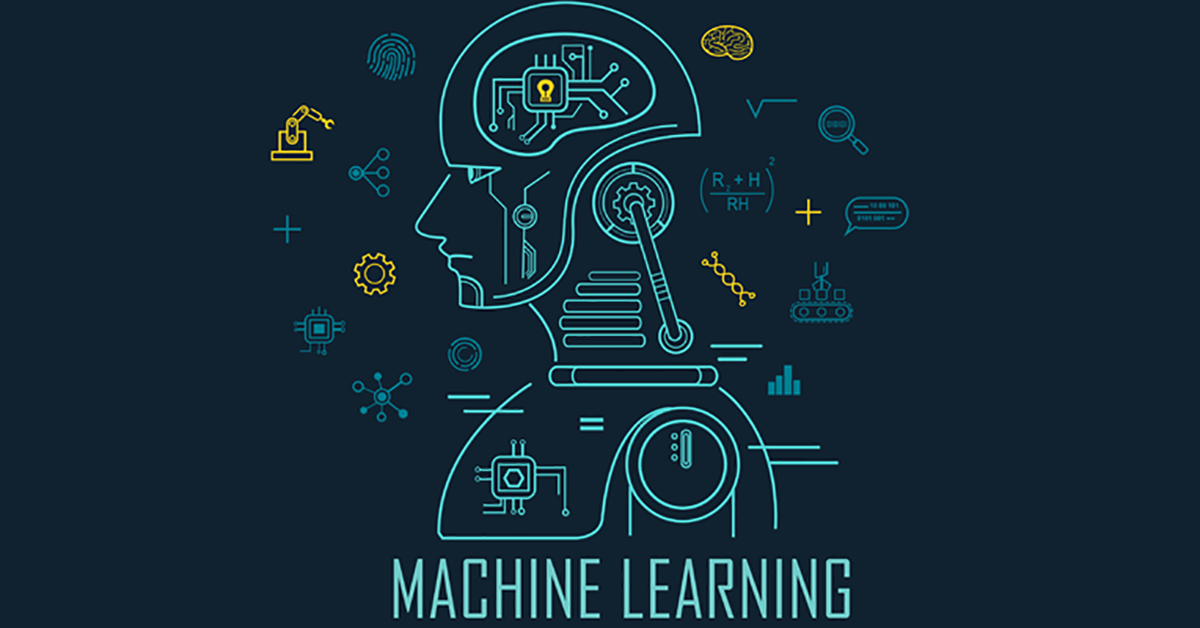

Maintenant, nous allons commencer la construction du modèle.

1. Nous commencerons par un modèle aléatoire pour créer une ligne de base et ainsi comparer nos modèles sensibles à ces résultats.
2. Ensuite, nous passerons à la régression logistique et au SVM linéaire. Nous n'utilisons pas le SVM à noyau en raison de sa complexité temporelle élevée. Les classifieurs tels que la régression logistique et le SVM linéaire fonctionnent très bien lorsque les données sont de dimension élevée.
3. Ensuite, nous passerons aux ensembles, en commençant par les techniques de Bagging telles que les classifieurs RandomForest et ExtraTrees (Pour des raisons de durée de traitement,nous n'avions plus utilisés ces algos). Nous utiliserons également des classifieurs de boosting pour comparer davantage les performances. Étant donné que le bagging sera effectué avec des arbres de décision très profonds, la complexité temporelle de l'entraînement peut être élevée pour une telle dimensionnalité élevée.
4. Étant donné que nous utilisons l'AUC comme indicateur clé de performance pour ajuster les modèles et qu'il s'agit d'un problème de classification déséquilibrée, il se peut que nous devions ajuster le seuil de classification pour certains des modèles qui ne donnent pas des probabilités exactes. Nous utiliserons la courbe ROC pour ajuster le seuil.
5. Enfin, nous ferons du stacking et du blending pour voir si cela permet d'améliorer davantage les modèles.

Remarque :
Nous traitons les valeurs NaN en les remplaçant par des zéros uniquement pour les modèles Sklearn. Les méthodes de boosting telles que XGBoost, LightGBM gèrent naturellement les valeurs NaN en tant que catégories, nous n'avons donc pas besoin de les imputer explicitement.

## Model Random 

Un modèle random, ou modèle aléatoire, est une approche de modélisation qui repose sur l'utilisation de processus ou de variables aléatoires pour générer des prédictions ou des résultats. Contrairement à d'autres modèles basés sur des règles ou des paramètres déterministes, un modèle random incorpore l'incertitude inhérente dans les données ou les phénomènes étudiés. Ces modèles peuvent être utilisés pour simuler des scénarios stochastiques, générer des échantillons aléatoires ou analyser des problèmes où l'incertitude est une composante essentielle. Les modèles random sont couramment utilisés dans de nombreux domaines tels que la statistique, l'économie, la science des données et la modélisation des systèmes complexes.

Ce modèle génère aléatoirement une valeur de probabilité entre 0 et 1 pour chaque point de données. Cela servira de modèle de référence, et tous nos modèles sensibles ne devraient pas avoir de performances inférieures à celles-ci.

Résultats de l'ensemble de données d'entraînement:
	Score ROC-AUC = 0.49865535410697415
	Score de précision = 0.08079511619876602
	Score de rappel = 0.49953675730110775
Matrice de confusion des données d'entraînement:


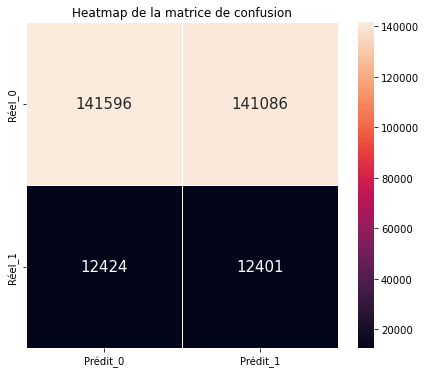

Distribution des étiquettes de classe d'origine et des étiquettes de classe prédites pour les données d'entraînement et de test


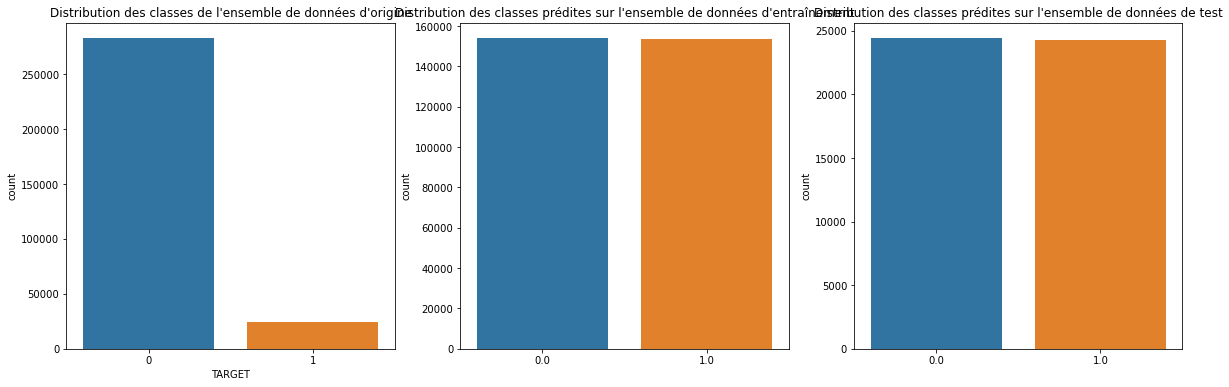

In [32]:
# Prédiction des probabilités pour les données d'entraînement
predicted_proba_train = np.random.uniform(0, 1, len(train_data))

# Prédiction des probabilités pour les données de test
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

# Affichage des résultats pour les données d'entraînement
print("=" * 100)
print("Résultats de l'ensemble de données d'entraînement:")
print(f"\tScore ROC-AUC = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tScore de précision = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tScore de rappel = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

# Affichage de la matrice de confusion pour les données d'entraînement
print("Matrice de confusion des données d'entraînement:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns=['Prédit_0', 'Prédit_1'], index=['Réel_0', 'Réel_1'])
plt.figure(figsize=(7, 6))
plt.title('Heatmap de la matrice de confusion')
sns.heatmap(conf_mat, annot=True, fmt='g', linewidth=0.5, annot_kws={'size': 15})
plt.show()
print('=' * 100)

# Affichage de la distribution des étiquettes de classe d'origine et des étiquettes de classe prédites pour les données d'entraînement et de test
print("Distribution des étiquettes de classe d'origine et des étiquettes de classe prédites pour les données d'entraînement et de test")
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title('Distribution des classes de l\'ensemble de données d\'origine')
sns.countplot(target_train)
plt.subplot(1, 3, 2)
plt.title('Distribution des classes prédites sur l\'ensemble de données d\'entraînement')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1, 3, 3)
plt.title('Distribution des classes prédites sur l\'ensemble de données de test')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)


<ul>
<li>D'après la matrice de confusion ci-dessus, nous constatons qu'il prédit un nombre presque égal d'étiquettes de classe positive et négative. Cela implique la complète aléatoire du modèle.
<li>De même, à partir des distributions des étiquettes de classe prédites, nous observons ce comportement.
<li>L'AUC pour le modèle aléatoire sur l'ensemble de données d'entraînement est proche de 0,5 et le score F1 est proche de 0,1.
<li>Une AUC similaire est observée à partir de l'ensemble de données de test, comme on peut le voir à partir de la soumission ci-dessus.
<li>Cela établit une référence pour toutes les métriques ici.
</ul>

## Modèle de classe dominante

<li>Dans ce modèle, nous prédirons tout comme la classe dominante, qui est l'étiquette de classe 0 dans notre cas. Nous verrons également les mesures de ce modèle, et une fois de plus, nos modèles pertinents doivent être meilleurs que celui-ci.
<li>Étant donné que nous calculons également la valeur ROC-AUC, nous prédirons de manière aléatoire une probabilité comprise entre 0 et 0,5 avec un seuil de 0,5, de sorte que tous les points soient classés en tant que 0.

Résultats de l'ensemble de données d'entraînement :
	Score ROC-AUC = 0.499267622239582
	Score de précision = 0.0
	Score de rappel = 0.0
Matrice de confusion des données d'entraînement :


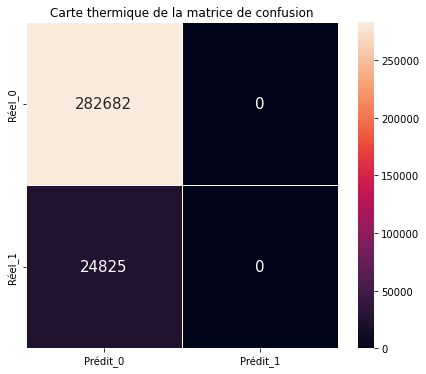

Répartition des étiquettes de classe d'origine et des étiquettes de classe prédites pour l'entraînement et le test


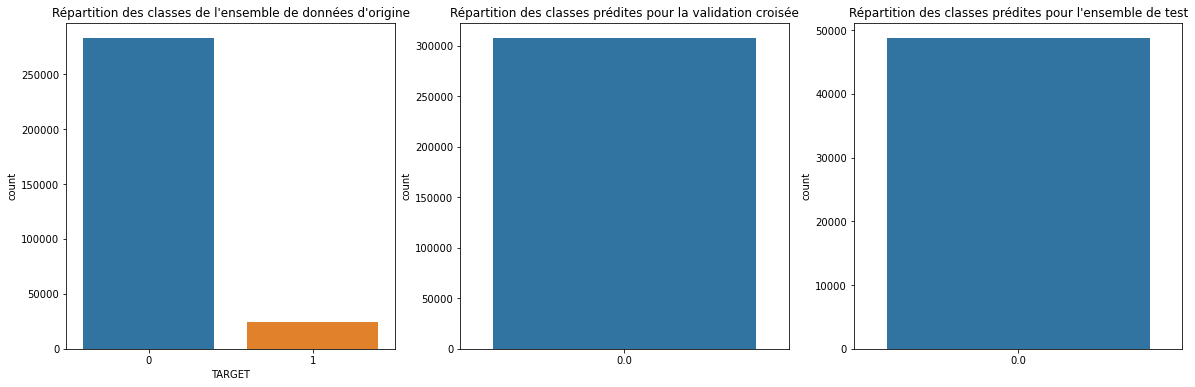

In [62]:
# Prédire tout avec une probabilité inférieure à 0.5, c'est-à-dire la classe majoritaire
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Résultats de l'ensemble de données d'entraînement :")
print(f"\tScore ROC-AUC = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tScore de précision = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tScore de rappel = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Matrice de confusion des données d'entraînement :")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns=['Prédit_0', 'Prédit_1'], index=['Réel_0', 'Réel_1'])
plt.figure(figsize=(7, 6))
plt.title('Carte thermique de la matrice de confusion')
sns.heatmap(conf_mat, annot=True, fmt='g', linewidth=0.5, annot_kws={'size': 15})
plt.show()
print('=' * 100)

print("Répartition des étiquettes de classe d'origine et des étiquettes de classe prédites pour l'entraînement et le test")
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title('Répartition des classes de l\'ensemble de données d\'origine')
sns.countplot(target_train)
plt.subplot(1, 3, 2)
plt.title('Répartition des classes prédites pour la validation croisée')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1, 3, 3)
plt.title('Répartition des classes prédites pour l\'ensemble de test')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

<li>À partir des résultats ci-dessus, nous observons que l'AUC reste sensiblement la même, soit 0,5.
<li>Cependant, le score F1 est maintenant de 0, car nous ne prédisons rien en tant que classe positive.
<li>La matrice de confusion montre également que tous les points sont négatifs, c'est-à-dire qu'il y a un grand nombre de faux négatifs, mais aucun faux positif.
<li>L'AUC de test est également cohérente avec l'entraînement, c'est-à-dire 0.499.

## Régression logistique avec régularisation L2

La régression logistique avec régularisation L2 est une technique d'apprentissage automatique utilisée pour les problèmes de classification binaire. Elle est similaire à la régression logistique classique, mais avec l'ajout d'une pénalité L2 (aussi appelée régularisation Ridge) pour limiter le surajustement du modèle. La régularisation L2 ajoute un terme à la fonction de perte qui favorise des coefficients de régression plus petits, ce qui conduit à un modèle plus simple et à une meilleure généralisation. La force de la régularisation peut être contrôlée en ajustant le paramètre de régularisation. La régression logistique avec régularisation L2 est couramment utilisée pour des ensembles de données présentant des problèmes de multicollinéarité ou de surajustement.

<li>Dans cette section, nous utiliserons SGDClassifier avec une perte logarithmique et une pénalité L2. Nous utiliserons GridSearchCV pour l'optimisation des hyperparamètres.
<li>Nous n'avons pas encore divisé les données en données d'entraînement et de validation croisée. Nous créerons les données de validation croisée à la volée, c'est-à-dire pendant l'optimisation des hyperparamètres.
<li>Pour les prédictions globales sur la validation croisée, nous utiliserons la méthode de K-Fold stratifiée avec les prédictions en tant que prédictions out-of-fold.
<li>Étant donné que nous optimisons les hyperparamètres pour l'AUC et que c'est également le cas d'un jeu de données déséquilibré, nous ajusterons le seuil pour obtenir le meilleur TPR et le plus faible TPR en utilisant la statistique J.

Effectuer une recherche aléatoire avec 15 initialisations aléatoires...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Terminé.
Temps écoulé = 0:09:51.796050


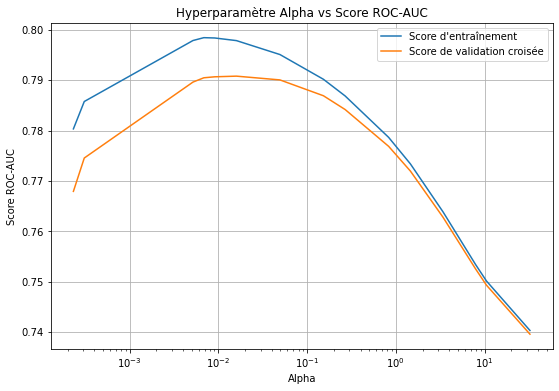

In [34]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

# Effectuons d'abord une recherche aléatoire avec validation croisée
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2)

# Visualisation des résultats de la validation croisée
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

# Tracé des scores d'entraînement et de validation croisée
plt.figure(figsize=(9, 6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label='Score d\'entraînement')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label='Score de validation croisée')
plt.title('Hyperparamètre Alpha vs Score ROC-AUC')
plt.xlabel('Alpha')
plt.ylabel('Score ROC-AUC')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Ajustement du classifieur sur les meilleurs paramètres

4-Fold Cross Validation
	Ajustement du pli 1
	Ajustement du pli 2
	Ajustement du pli 3
	Ajustement du pli 4
Terminé.
Temps écoulé = 0:00:59.540396

Le meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = 0.4751730793172198

Résultats sur les données d'entraînement :
	Score ROC-AUC = 0.7967199301086765
	Score de précision = 0.1806550064561568
	Score de rappel = 0.7439274924471299
Résultats sur la validation croisée :
	Score ROC-AUC = 0.7907636938949894
	Score de précision = 0.17888121791467515
	Score de rappel = 0.7326888217522659
Matrice de confusion des données de validation croisée :


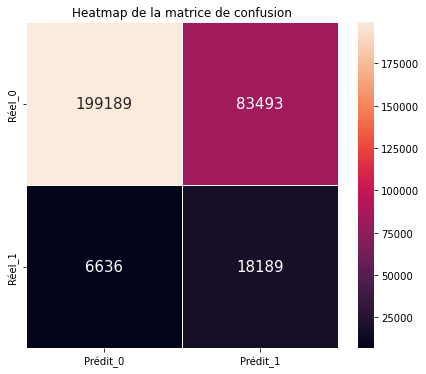

Distribution des étiquettes de classe originales et des étiquettes de classe prédites sur la validation croisée et les données de test


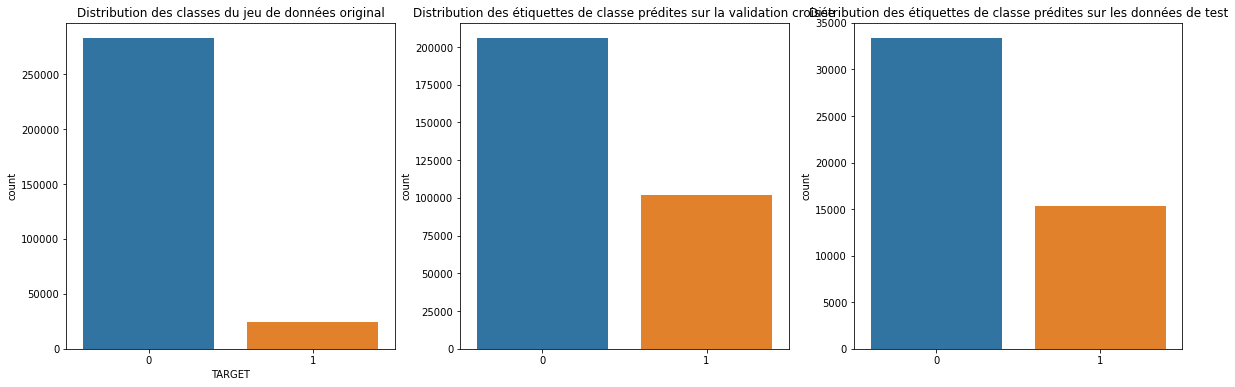

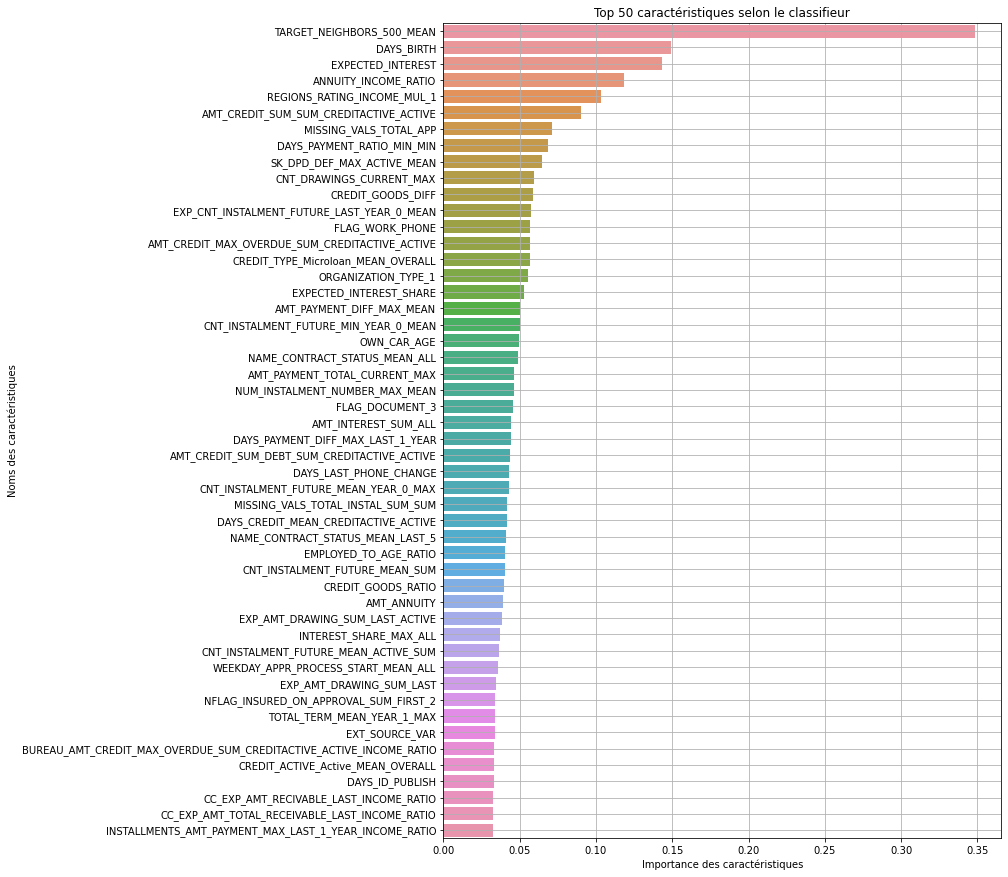

In [35]:
# Entraînement sur les meilleurs paramètres
sgd_lr_l2.train_on_best_params()

# Affichage des résultats
sgd_lr_l2.results_on_best_params('linear')

# Tracé des importances des caractéristiques
sgd_lr_l2.feat_importances_show(train_data.columns, num_features=50)

In [36]:
with open('SGD_LR_L2_Penalty_CV_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.cv_preds_probas, f)
with open('SGD_LR_L2_Penalty_Test_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.test_preds_probas, f)
with open('SGD_LR_L2_Penalty_Model.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.best_model, f)

<b>Discussion des résultats</b>

<ul><li>Nous avons d'abord ajusté l'hyperparamètre 'alpha' pour la régression logistique en utilisant RandomizedSearchCV avec une validation croisée à 4 plis.</li>
    <li>Nous avons ensuite utilisé le meilleur modèle obtenu pour l'ajuster sur l'ensemble de données d'entraînement.</li>
    <ul><li>D'après les scores AUC, nous constatons que les scores AUC d'entraînement et de validation croisée sont très proches l'un de l'autre. Cela signifie qu'il n'y a pas beaucoup de surajustement.</li>
        <li>Le score AUC du test est légèrement inférieur au score AUC de validation croisée. Il n'y a pas de grande différence entre le score AUC de validation croisée et de test, ce qui implique que l'ensemble de données de validation croisée et de test sont très similaires.</li>
        <li>Le seuil optimal de décision pour la probabilité est de 0,47, ce qui est proche de 0,5. Cela est dû au fait que la régression logistique renvoie intrinsèquement la probabilité de la vraie classe.</li>
        <li>D'après la matrice de confusion, nous constatons qu'il y a beaucoup de faux positifs. Le nombre de faux négatifs est en réalité plus faible.
        <li>Nous constatons que la précision de notre modèle est très faible. Cependant, la valeur du rappel est en réalité bonne. C'est ce que nous voulons, c'est-à-dire qu'aucun mauvais payeur ne doit être manqué même si certains bons payeurs sont classés comme mauvais payeurs, car ils peuvent ensuite faire une nouvelle demande, mais si un mauvais payeur est manqué par le modèle, cela pourrait causer beaucoup de pertes pour l'entreprise.</li>
        <li>Si nous examinons la distribution des étiquettes de classe prédites par rapport aux étiquettes de classe réelles, nous constatons qu'il y a beaucoup plus d'étiquettes de classe positives prédites qu'il n'y en a réellement. Cela implique encore une fois la faible valeur de la précision.</li>
        <li>Nous constatons également que les étiquettes de classe prédites parmi les ensembles de données de validation croisée et de test suivent une distribution très similaire, ce qui implique que le modèle se comporte de manière similaire sur les ensembles de données de validation croisée et de test.</li>
        <li>Nous avons tracé les 50 principales fonctionnalités selon le classifieur. La fonctionnalité ayant le score le plus élevé est la moyenne des valeurs cibles de 500 voisins. Nous constatons également qu'une autre fonctionnalité générée, c'est-à-dire l'intérêt attendu, obtient également un score assez élevé. Cela signifie que nos fonctionnalités générées aident réellement dans la tâche de classification.</li>

## SVM linéaire

Un SVM linéaire (Support Vector Machine linéaire) est un algorithme d'apprentissage automatique utilisé pour la classification et la régression. Il est basé sur la recherche d'un hyperplan linéaire optimal qui sépare les données en différentes classes. L'objectif du SVM linéaire est de trouver cet hyperplan de manière à maximiser la marge entre les données de différentes classes. Cela permet de généraliser efficacement les prédictions pour de nouvelles données. Le SVM linéaire peut être utilisé pour des problèmes de classification binaire et peut être étendu à des problèmes de classification multiclasse. Il est connu pour sa capacité à traiter des ensembles de données de grande dimension.

Dans cette section, nous allons encore entraîner un SGDClassifier avec une pénalité L2 mais avec une perte de charnière, pour le cas de SVM linéaire. Nous n'utiliserons pas SVM à noyau en raison de la complexité élevée du temps d'entraînement, étant donné que le nombre de points de données est très élevé dans notre cas.

Effectuer une recherche aléatoire avec 15 initialisations aléatoires...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Terminé.
Temps écoulé = 0:12:34.448876


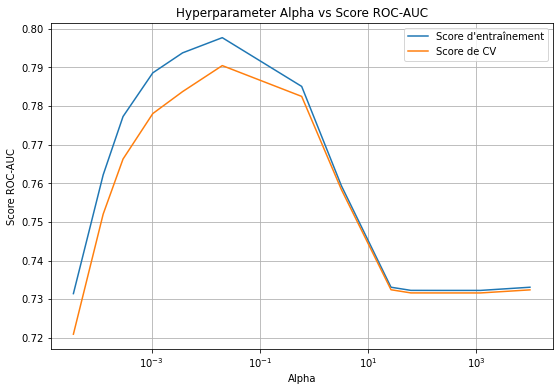

In [37]:
params = {
    'loss' : 'hinge',
    'class_weight' : 'balanced',
    'random_state' : 129,
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {
    'alpha' : np.logspace(-5,4) 
}
linear_svm = modelling(clf, x_train_std, y_train, x_test_std, calibration = True)

# commençons par la recherche aléatoire CV
linear_svm.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2, random_state = 693)

# visualisation des résultats de CV
cv_results = linear_svm.tuning_results
cv_results = cv_results.sort_values('param_alpha')

# tracé des scores d'entraînement et de CV
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Score d\'entraînement')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'Score de CV')
plt.title('Hyperparameter Alpha vs Score ROC-AUC')
plt.xlabel('Alpha')
plt.ylabel('Score ROC-AUC')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Ajustement du classifieur sur les meilleurs paramètres

4-Fold Cross Validation
	Ajustement du pli 1
	Ajustement du pli 2
	Ajustement du pli 3
	Ajustement du pli 4
Terminé.
Temps écoulé = 0:04:09.501184

Le meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = 0.08268435708854575

Résultats sur les données d'entraînement :
	Score ROC-AUC = 0.7981013689525606
	Score de précision = 0.18601410067224136
	Score de rappel = 0.7311983887210474
Résultats sur la validation croisée :
	Score ROC-AUC = 0.7915152564010789
	Score de précision = 0.1826442155874054
	Score de rappel = 0.7222557905337361
Matrice de confusion des données de validation croisée :


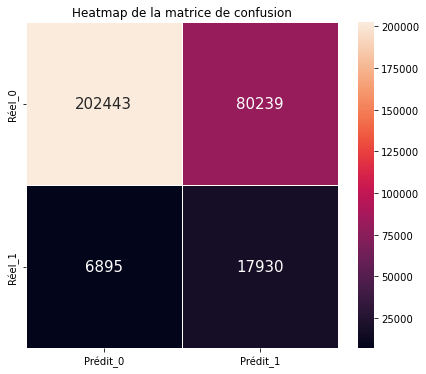

Distribution des étiquettes de classe originales et des étiquettes de classe prédites sur la validation croisée et les données de test


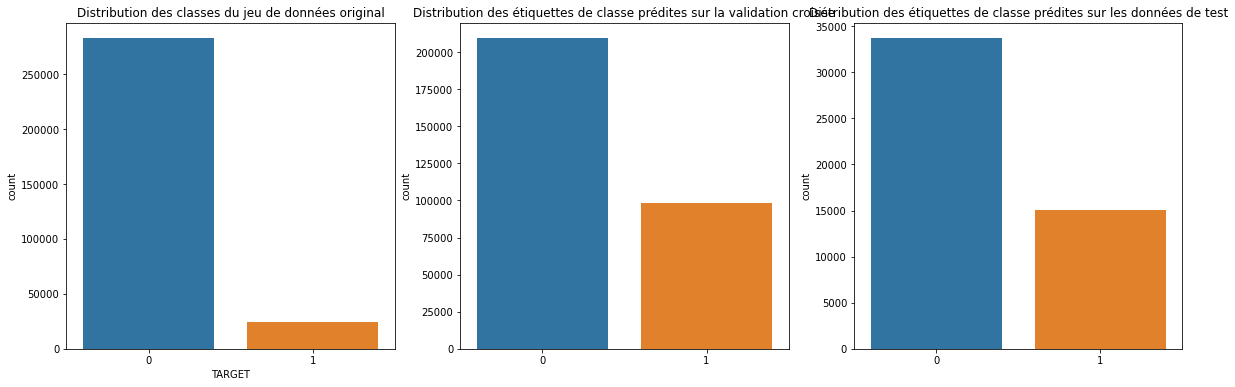

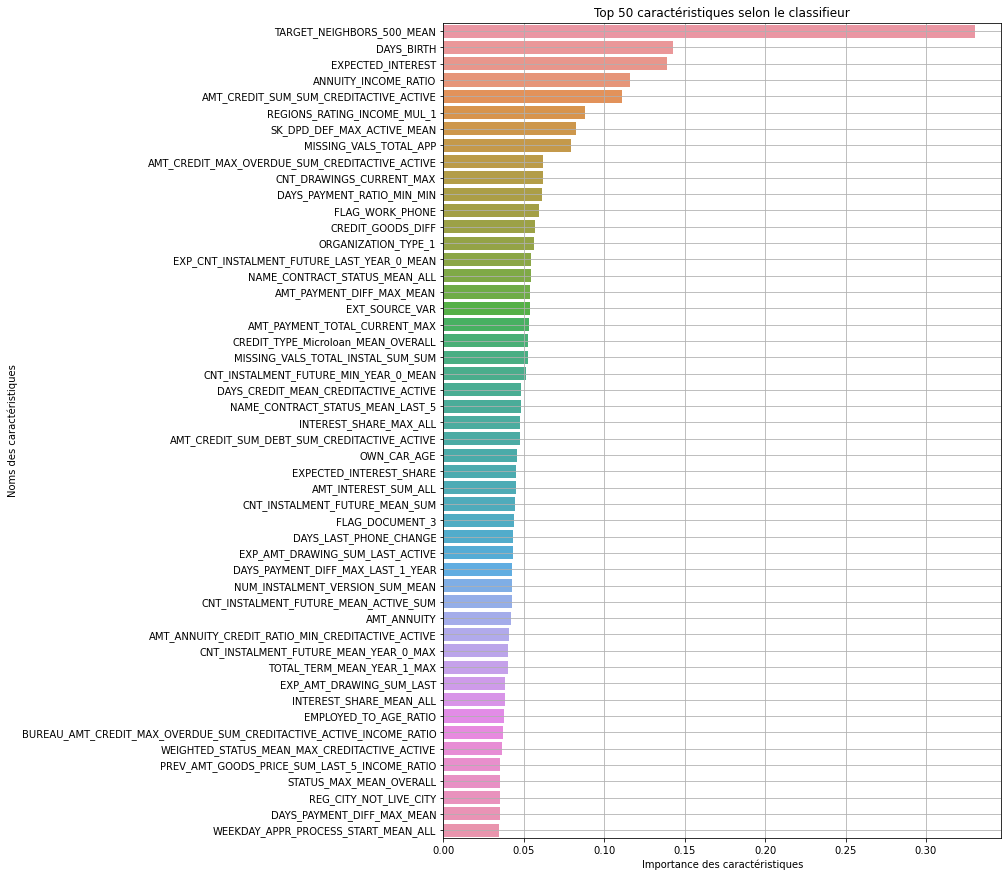

In [38]:
# Entraînement sur les meilleurs paramètres
linear_svm.train_on_best_params()

# Affichage des résultats
linear_svm.results_on_best_params('linear')

# Tracé de l'importance des caractéristiques
linear_svm.feat_importances_show(train_data.columns, num_features = 50)

In [39]:
with open('SGD_Linear_SVM_CV_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.cv_preds_probas, f)
with open('SGD_Linear_SVM_Test_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.test_preds_probas, f)
with open('SGD_Linear_SVM_Model.pkl', 'wb') as f:
    pickle.dump(linear_svm.best_model, f)

# Conclusion

Les résultats de la régression logistique et du SVM linéaire sont très similaires, comme on pouvait s'y attendre. Les scores AUC pour l'entraînement, la validation croisée et les tests sont tous assez proches, avec une légère amélioration pour le SVM linéaire. Les valeurs de seuil de probabilité pour la prise de décision diffèrent légèrement, mais les valeurs de précision et de rappel restent globalement les mêmes.

Les matrices de confusion montrent des performances similaires en termes de vrais positifs et de faux positifs, avec une légère diminution des vrais positifs pour le SVM linéaire.

Les 50 principales caractéristiques importantes sont également très similaires entre la régression logistique et le SVM linéaire.

En conclusion, la régression logistique et le SVM linéaire se comportent de manière très similaire dans ce cas, ce qui était attendu étant donné les similitudes entre les deux approches.

## XGBoost GPU

XGBoost (eXtreme Gradient Boosting) est une bibliothèque open-source populaire pour l'apprentissage automatique qui implémente l'algorithme de boosting basé sur les arbres de décision. Il est connu pour sa grande performance et sa précision dans les tâches de régression et de classification. XGBoost utilise un processus itératif pour construire des arbres de décision en optimisant une fonction de perte spécifique. Il inclut des fonctionnalités telles que la régularisation, l'échantillonnage des données et la gestion des catégories pour améliorer les performances et prévenir le surajustement. XGBoost est largement utilisé dans les compétitions de science des données et dans les applications du monde réel.

Pour à la fois XGBoost et LightGBM, nous avons trop de paramètres à régler, et l'utilisation de GridSearchCV ou RandomizedSearchCV peut être trop coûteuse sur un ensemble de données aussi volumineux pour trouver une solution optimale. C'est pourquoi nous utiliserons la technique d'optimisation bayésienne pour régler les hyperparamètres. Cette technique fonctionne en examinant les résultats obtenus avec les hyperparamètres précédents tout en assignant de nouveaux hyperparamètres. Elle tente de modéliser la fonction de coût qui dépend de tous les hyperparamètres.

### Optimisation Bayésienne

In [40]:
def xgb_evaluation(max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
                   colsample_bynode, reg_alpha, reg_lambda):
    '''
    Fonction objectif pour l'optimisation bayésienne des hyperparamètres de XGBoost.
    Prend les hyperparamètres en entrée et renvoie le score AUC de la validation croisée en sortie.
    
    Entrées : Hyperparamètres à régler.
        max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
        colsample_bynode, reg_alpha, reg_lambda
        
    Renvoie :
        Score ROC-AUC de la validation croisée
    '''
    params = {
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'max_depth': int(round(max_depth)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': subsample,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'colsample_bynode': colsample_bynode,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'random_state': 51412
    }    
    
    # Définition de la stratégie de validation croisée
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=33)
    cv_preds = np.zeros(train_data.shape[0])
    
    # Itération sur chaque fold, entraînement du modèle et prédiction Out-of-Fold
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]
        
        xgbc = XGBClassifier(**params)
        xgbc.fit(x_tr, y_tr, eval_set=[(x_cv, y_cv)],
                 eval_metric='auc', verbose=False, early_stopping_rounds=200)
        
        cv_preds[cv_indices] = xgbc.predict_proba(x_cv, ntree_limit=xgbc.get_booster().best_ntree_limit)[:, 1]
        gc.collect()   
        
    return roc_auc_score(target_train, cv_preds)

In [41]:
#définissons l'optimiseur et les hyperparamètres avec les plages de valeurs
bopt_xgb =  BayesianOptimization(xgb_evaluation, {'max_depth' : (5,15),
                                                  'min_child_weight' : (5,80),
                                                  'gamma' : (0.2,1),
                                                  'subsample' : (0.5,1),
                                                  'colsample_bytree' : (0.5,1),
                                                  'colsample_bylevel' : (0.3,1),
                                                  'colsample_bynode' : (0.3,1),
                                                  'reg_alpha' : (0.001, 0.3),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_xgb.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.805     | 0.3652    | 0.9802    | 0.7419    | 0.394     | 10.31     | 26.42     | 0.2589    | 0.01329   | 0.5542    |
| 2         | 0.8044    | 0.837     | 0.336     | 0.8879    | 0.2073    | 11.18     | 66.4      | 0.2697    | 0.2957    | 0.7484    |
| 3         | 0.8051    | 0.5466    | 0.907     | 0.6984    | 0.7149    | 5.205     | 65.61     | 0.1295    | 0.168     | 0.8896    |
| 4         | 0.8048    | 0.5818    | 0.9356    | 0.825     | 0.7818    | 12.8      | 31.3      | 0.006878  | 0.1082    | 0.6516    |
| 5         | 0.8051    | 0.8057    | 0.7387    | 0.8461    | 0.9899    | 5.404     | 74.35     | 0.1637    | 0.2228    | 0.9098    |
| 6         | 0.8025    | 0.642     | 0.9929    | 0.5992    | 

In [42]:
# Extraction des meilleurs paramètres
target_values = []
for result in bopt_xgb.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
    
print("Meilleurs hyperparamètres pour XGBoost :\n")
print(best_params)

Meilleurs hyperparamètres pour XGBoost :

{'colsample_bylevel': 0.8705421217379983, 'colsample_bynode': 0.9637675045385672, 'colsample_bytree': 0.7204810901956585, 'gamma': 0.9771733266902063, 'max_depth': 5.032255803174176, 'min_child_weight': 48.487990502888714, 'reg_alpha': 0.24723061448193434, 'reg_lambda': 0.21645652412136718, 'subsample': 0.7031951230057991}


### Entrainement sur des hyper-paramètres optimisés

In [43]:
params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'max_depth' : 5,
        'min_child_weight' : 48,
        'subsample': 0.7031951230057991,
        'gamma' : 0.9771733266902063,
        'colsample_bytree' : 0.7204810901956585,
        'colsample_bylevel' :  0.8705421217379983,
        'colsample_bynode' : 0.9637675045385672,
        'reg_alpha' : 0.24723061448193434,
        'reg_lambda' : 0.21645652412136718,
        'random_state' : 51412,
    }    
   
xgb_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting.train(booster = 'xgboost')

Entraînement du xgboost sur les données d'entraînement avec 3 folds de validation croisée, en utilisant les prédictions hors échantillon pour la validation croisée

	Fold numéro 1

[0]	validation_0-auc:0.75844	validation_1-auc:0.75755
[400]	validation_0-auc:0.79692	validation_1-auc:0.78787
[800]	validation_0-auc:0.81877	validation_1-auc:0.79932
[1200]	validation_0-auc:0.83163	validation_1-auc:0.80343
[1600]	validation_0-auc:0.84179	validation_1-auc:0.80552
[2000]	validation_0-auc:0.85037	validation_1-auc:0.80664
[2400]	validation_0-auc:0.85804	validation_1-auc:0.80727
[2800]	validation_0-auc:0.86503	validation_1-auc:0.80758
[3200]	validation_0-auc:0.87138	validation_1-auc:0.80768
[3600]	validation_0-auc:0.87768	validation_1-auc:0.80779
[3981]	validation_0-auc:0.88303	validation_1-auc:0.80783

	Fold numéro 2

[0]	validation_0-auc:0.76061	validation_1-auc:0.75226
[400]	validation_0-auc:0.79786	validation_1-auc:0.78175
[800]	validation_0-auc:0.81930	validation_1-auc:0.79541
[1200]	validat

Résultats de l'entraînement :

Le meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = 0.04696259399255117

	Score ROC-AUC = 0.874621271791155
	Score de précision = 0.24418661816036577
	Score de rappel = 0.8003222557905337
Résultats de la validation croisée :
	Score ROC-AUC = 0.8051792519121244
	Score de précision = 0.1467184907936769
	Score de rappel = 0.8621550855991944
Matrice de confusion des donnéesCV :


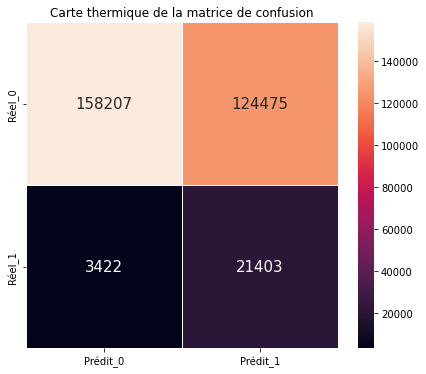

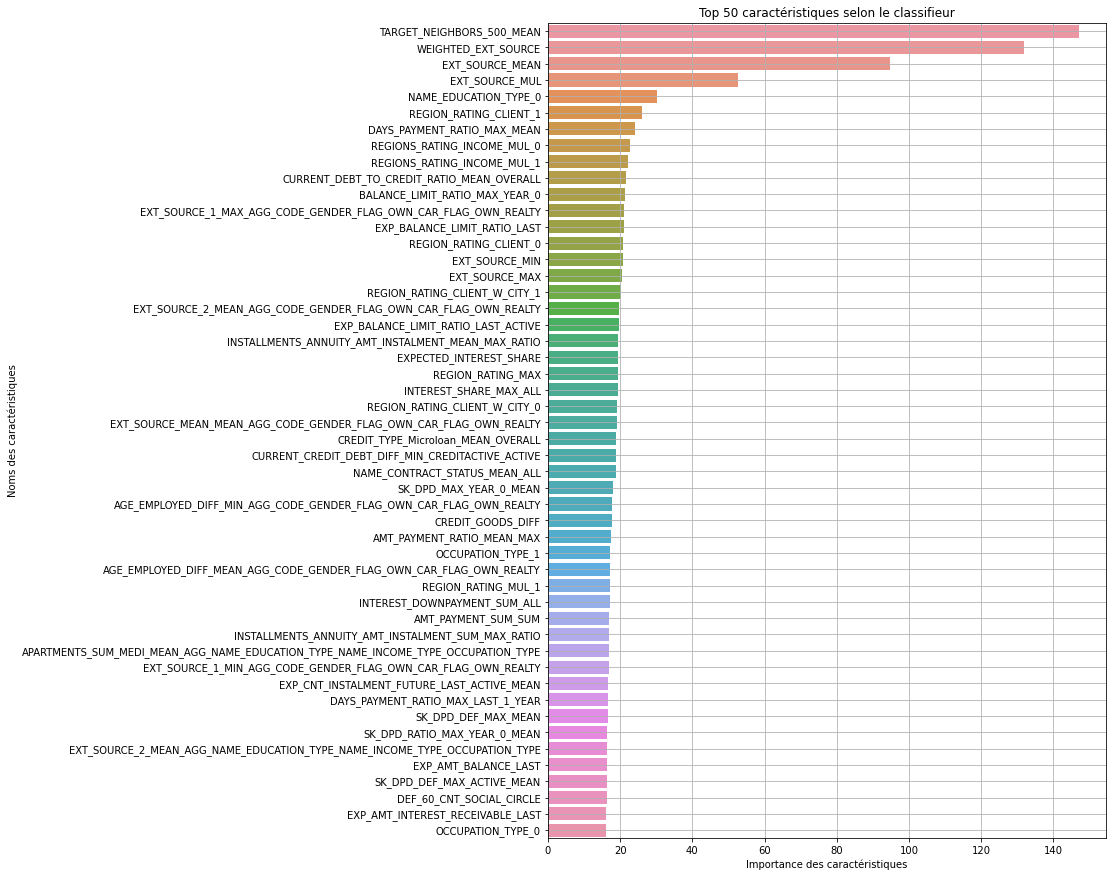

In [44]:
# Affichage des résultats et des métriques
xgb_boosting.results()
# Affichage des 50 principales fonctionnalités importantes
xgb_boosting.feat_importances_show(50)

In [45]:
features_with_zero_importances = xgb_boosting.feature_importance[xgb_boosting.feature_importance.gain == 0]

print(f"Il y a {len(features_with_zero_importances)} fonctionnalités avec un gain nul dans XGBClassifier. Ce sont :\n")
print(features_with_zero_importances.features.values)

Il y a 50 fonctionnalités avec un gain nul dans XGBClassifier. Ce sont :

['INTEREST_CREDIT_PRIVILEGED_MEAN_FIRST_2'
 'WEIGHTED_STATUS_MEAN_MAXCREDIT_ACTIVE_REST' 'FLAG_OWN_CAR_1'
 'MAX_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL'
 'AMT_CREDIT_MAX_OVERDUE_SUMCREDIT_ACTIVE_REST' 'FLAG_MOBIL'
 'WEIGHTED_STATUS_MEAN_MEANCREDIT_ACTIVE_REST' 'FLAG_EMP_PHONE'
 'NAME_CONTRACT_TYPE_0' 'NAME_CONTRACT_TYPE_1'
 'CREDIT_TYPE_Loan for business development_MEAN_OVERALL'
 'CNT_PROLONGED_DURATION_RATIO_MEAN_OVERALL'
 'DAYS_ENDDATE_FACT_MEAN_CREDITACTIVE_CLOSED'
 'CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MAX_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MEAN_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MEAN_OVERALL' 'FLAG_DOCUMENT_17' 'FLAG_DOCUMENT_14'
 'AMT_REQ_CREDIT_BUREAU_HOUR' 'DAYS_ENDDATE_FACT_MIN_CREDITACTIVE_CLOSED'
 'CURRENT_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL' 'FLAG_DOCUMENT_11'
 'FLAG_CONT_MOBILE'
 'EXT_SOURCE_3_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME

In [46]:
with open('xgb_imp_feats.pkl','wb') as f:
    pickle.dump(xgb_boosting.feature_importance, f)
with open('xgb_cv_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.cv_preds_proba, f)
with open('xgb_test_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.test_preds_proba_mean, f)

<b>Discussion des résultats</b>

<ul>
  <li>Le modèle XGBoost avec des hyperparamètres optimisés semble performant mieux que tous les modèles utilisés jusqu'à présent, avec une marge significative. Ces résultats sont reflétés à la fois pour la validation croisée et les scores de test.</li>

  <li>Le score de validation croisée et le score de test AUC sont très proches, ce qui implique une distribution similaire entre les données d'entraînement et les données de test.</li>
  <li>Nous remarquons ici que la valeur de rappel (recall) pour l'ensemble de validation croisée est en réalité supérieure à celle de l'ensemble d'entraînement, mais les valeurs de précision sont très faibles.</li>
  <li>En regardant la matrice de confusion, nous constatons qu'il y a très peu de faux négatifs, mais le nombre de faux positifs est assez élevé. Il s'agit du compromis entre le rappel et la précision que nous devons prendre en compte.</li>
  <li>Nous avons ajusté le seuil en utilisant la courbe ROC-AUC, qui tente de maximiser le taux de vrais positifs (ce que nous pouvons également observer à partir de la matrice de confusion) et de minimiser le taux de faux positifs, qui est proche de 0,047 ici.</li>
</ul>

<ul>
  <b>Importance des fonctionnalités</b>
  <li>Les méthodes basées sur les arbres fournissent des importances de fonctionnalités pertinentes. Nous constatons que la fonctionnalité avec le score de gain Gini le plus élevé est "EXT_SOURCE_MEAN", qui représente la moyenne de toutes les valeurs "EXT_SOURCE". Nous voyons également de nombreuses fonctionnalités générées à partir de "EXT_SOURCE" parmi les fonctionnalités les mieux classées. Nous remarquons également que la moyenne de la cible des 500 voisins est la cinquième fonctionnalité la mieux classée. Parmi les autres fonctionnalités, nous remarquons que les fonctionnalités générées à partir des interactions catégorielles dans la table "application_train" ont également obtenu de bons scores selon le modèle.</li>
  <li>Sur les 1236 fonctionnalités, nous constatons que 50 fonctionnalités ont un gain de Gini exactement égal à 0, et il serait préférable de les supprimer si nous devions utiliser ce classifieur.</li>
</ul>

### Analyse des importances des caractéristiques à partir de XGBoost
Analysons les importances des caractéristiques obtenues à partir du modèle XGBoost.

In [47]:
xgb_feat_imp = xgb_boosting.feature_importance

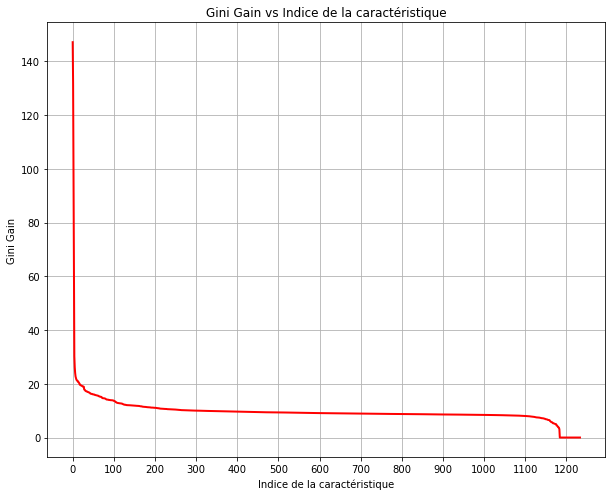

In [48]:
# Tracé de l'importance par rapport à l'indice de la caractéristique pour les caractéristiques
plt.figure(figsize=(10, 8))
plt.plot(list(range(len(xgb_feat_imp))), xgb_feat_imp.gain, color='r', linewidth=2)
plt.xlabel('Indice de la caractéristique')
plt.ylabel('Gini Gain')
plt.xticks(list(range(0, 1300, 100)))
plt.grid()
plt.title("Gini Gain vs Indice de la caractéristique")
plt.show()

À partir de la figure ci-dessus, nous remarquons qu'il y a un point d'inflexion autour de 100 caractéristiques, après quoi le gain diminue très rapidement. Essayons d'exclure ces 100 premières caractéristiques les plus importantes et observons davantage de caractéristiques.

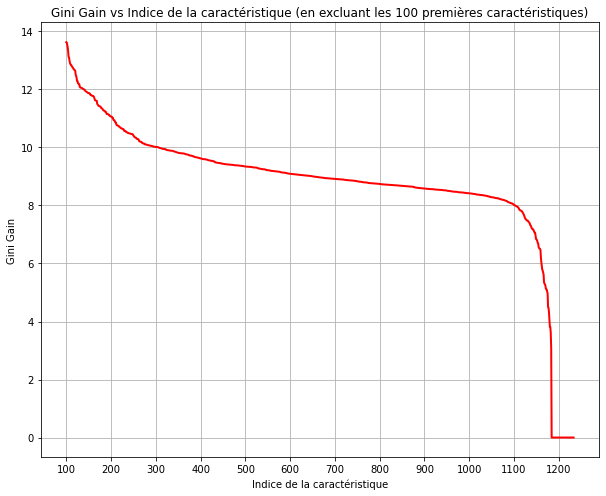

In [49]:
# Tracé de l'importance par rapport à l'indice de la caractéristique pour les caractéristiques
plt.figure(figsize=(10, 8))
plt.plot(list(range(len(xgb_feat_imp) - 100)), xgb_feat_imp.gain.iloc[100:], color='r', linewidth=2)
plt.xlabel('Indice de la caractéristique')
plt.ylabel('Gini Gain')
plt.xticks(ticks=list(range(0, 1200, 100)), labels=list(range(100, 1300, 100)))
plt.grid()
plt.title("Gini Gain vs Indice de la caractéristique (en excluant les 100 premières caractéristiques)")
plt.show()

Ici encore, nous constatons un point d'inflexion ou une chute de l'importance des caractéristiques / du gain de Gini à l'indice de la caractéristique entre 500 et 600. Nous allons donc prendre les 600 premières caractéristiques et essayer de modéliser le XGBoostClassifier avec les mêmes paramètres sur cet ensemble réduit de paramètres, puis comparer les performances.

## XGBoost GPU sur un ensemble de caractéristiques réduit

In [50]:
# Réduction de l'ensemble de caractéristiques
# Prendre les 600 premières caractéristiques les mieux classées
train_data_600 = train_data[xgb_feat_imp.features.iloc[:600]]
test_data_600 = test_data[xgb_feat_imp.features.iloc[:600]]

print(f"Forme des données d'entraînement avec un ensemble de caractéristiques réduit = {train_data_600.shape}")
print(f"Forme des données de test avec un ensemble de caractéristiques réduit = {test_data_600.shape}")

Forme des données d'entraînement avec un ensemble de caractéristiques réduit = (307507, 600)
Forme des données de test avec un ensemble de caractéristiques réduit = (48744, 600)


### Entrainement du modèle

In [51]:
# Entraînement sur les paramètres déjà optimisés ci-dessus
xgb_boosting_600 = Boosting(train_data_600, target_train, test_data_600, params, random_state=98, save_model_to_pickle=True)
xgb_boosting_600.train(booster='xgboost', pickle_name='600feats')

Entraînement du xgboost sur les données d'entraînement avec 3 folds de validation croisée, en utilisant les prédictions hors échantillon pour la validation croisée

	Fold numéro 1

[0]	validation_0-auc:0.73685	validation_1-auc:0.73659
[400]	validation_0-auc:0.79685	validation_1-auc:0.78774
[800]	validation_0-auc:0.81813	validation_1-auc:0.79944
[1200]	validation_0-auc:0.83035	validation_1-auc:0.80384
[1600]	validation_0-auc:0.83964	validation_1-auc:0.80562
[2000]	validation_0-auc:0.84765	validation_1-auc:0.80657
[2400]	validation_0-auc:0.85467	validation_1-auc:0.80713
[2800]	validation_0-auc:0.86102	validation_1-auc:0.80748
[3200]	validation_0-auc:0.86689	validation_1-auc:0.80756
[3276]	validation_0-auc:0.86799	validation_1-auc:0.80759

	Fold numéro 2

[0]	validation_0-auc:0.74085	validation_1-auc:0.72973
[400]	validation_0-auc:0.79770	validation_1-auc:0.78180
[800]	validation_0-auc:0.81849	validation_1-auc:0.79547
[1200]	validation_0-auc:0.83016	validation_1-auc:0.80023
[1600]	validat

Résultats de l'entraînement :

Le meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = 0.046203117817640305

	Score ROC-AUC = 0.8673657660778006
	Score de précision = 0.23665197601329382
	Score de rappel = 0.7916616314199396
Résultats de la validation croisée :
	Score ROC-AUC = 0.804902562181455
	Score de précision = 0.14521907233915995
	Score de rappel = 0.8654179254783484
Matrice de confusion des donnéesCV :


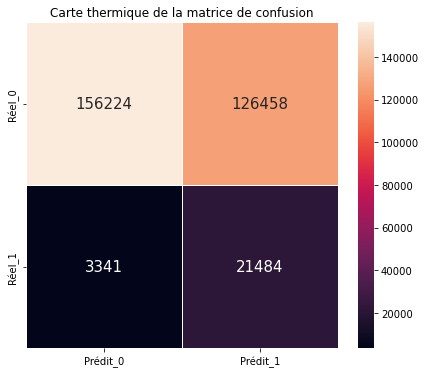

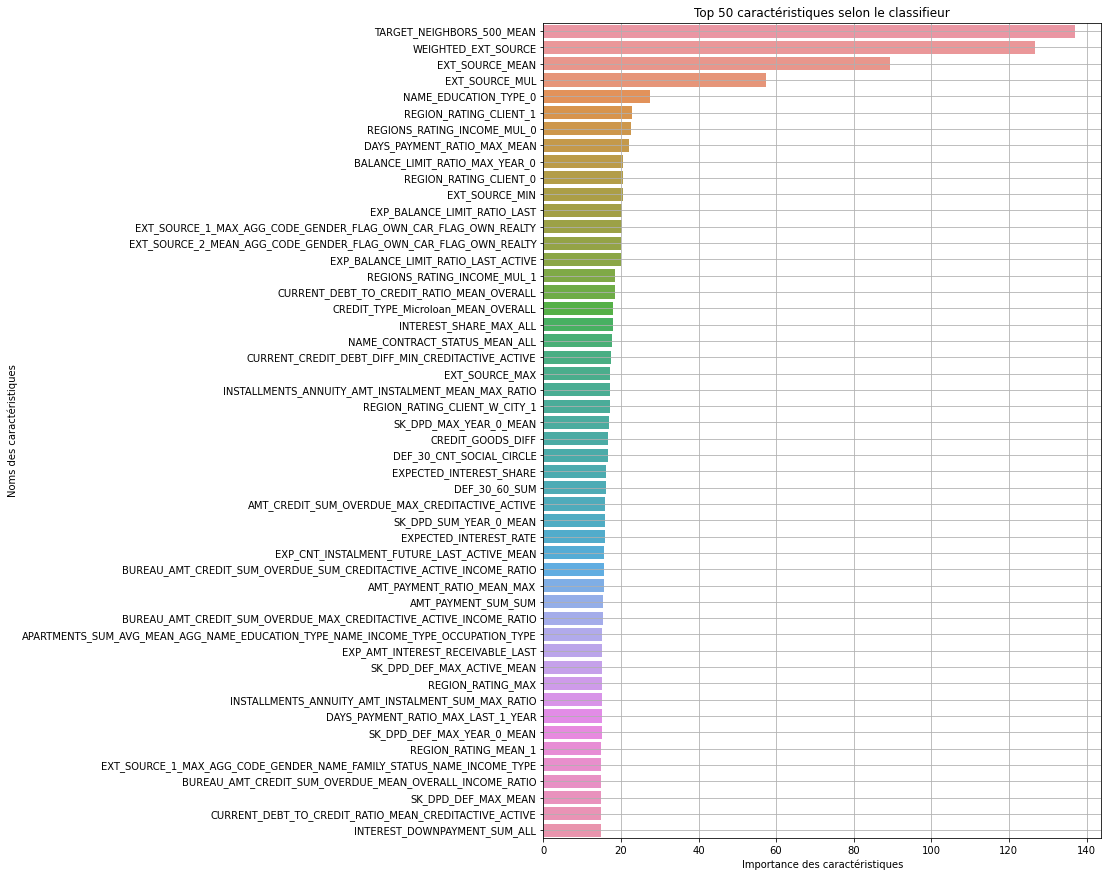

In [52]:
# Affichage des résultats et des métriques
xgb_boosting_600.results()
# Affichage des 50 principales caractéristiques importantes
xgb_boosting_600.feat_importances_show(50)

In [53]:
with open('xgb_imp_feats_600feats.pkl','wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance, f)
with open('xgb_cv_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.cv_preds_proba, f)
with open('xgb_test_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.test_preds_proba_mean, f)
with open('Final_XGBOOST_Selected_features', 'wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance.features.values, f)

<b>Discussion des résultats</b>

<ol>
    <li>D'après les résultats, nous observons que l'écart entre le score ROC-AUC de la validation croisée (CV) et le score ROC-AUC de l'entraînement s'est réduit, ce qui indique une légère réduction de la sur-adaptation par rapport au modèle avec les 1236 caractéristiques.</li>
    <li>Nous remarquons également que le rappel (recall) s'est amélioré, tandis que la précision a légèrement diminué.</li>
    <li>Le point précédent peut également être constaté en examinant la matrice de confusion, qui a signalé un plus grand nombre de vrais positifs.</li>
    <li>Les importances des caractéristiques restent plus ou moins les mêmes.</li>
</ol>

Ainsi, nous pouvons conclure qu'en supprimant des ensembles de caractéristiques, nous avons amélioré à la fois les performances et réduit la complexité de calcul de notre modèle.

## LightGBM

LightGBM (Gradient Boosting Machine) est une bibliothèque open-source développée par Microsoft qui permet d'effectuer de l'apprentissage automatique avec des modèles de boosting. Il s'agit d'une implémentation rapide et efficace de l'algorithme de boosting basé sur les arbres de décision. LightGBM utilise des techniques d'élagage et de division des arbres optimisées pour réduire le temps de formation et améliorer les performances. Il offre également des fonctionnalités avancées telles que la gestion des catégories, la régularisation et l'échantillonnage des données pour traiter efficacement les problèmes de grande échelle. LightGBM est largement utilisé dans les compétitions de science des données et dans les applications du monde réel.

### Optimisation bayésienne

In [54]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Fonction objectif pour l'optimisation bayésienne des hyperparamètres de LightGBM. Prend les hyperparamètres en entrée
    et renvoie le score de validation croisée ROC-AUC en sortie.
    
    Entrées : Hyperparamètres à régler.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Renvoie :
        Score ROC-AUC de la validation croisée
    '''
    
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': 0.005,
        'n_estimators': 10000,  # Réduire le nombre d'estimateurs
        'n_jobs': -1,
        'num_leaves': int(round(num_leaves)),
        'max_depth': int(round(max_depth)),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'min_child_samples': int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq': 1,  # Utiliser un subsample_freq plus élevé
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'verbosity': -1,
        'seed': 266
    }
    
    stratified_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=33)  # Réduire le nombre de folds
    
    cv_preds = np.zeros(train_data.shape[0])
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set=[(x_cv, y_cv)],
                     eval_metric='auc', verbose=False, early_stopping_rounds=200)  # Réduire early_stopping_rounds

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(target_train, cv_preds)

In [55]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (25,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (5,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.001, 0.3),
                                                   'reg_lambda' : (0.001, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8039    | 0.9839    | 9.624     | 65.58     | 60.98     | 0.08223   | 39.55     | 0.1133    | 0.2049    | 0.6677    |
| 2         | 0.8046    | 0.5453    | 10.99     | 36.09     | 42.7      | 0.02383   | 43.12     | 0.1206    | 0.1951    | 0.8343    |
| 3         | 0.804     | 0.7313    | 9.478     | 47.08     | 53.08     | 0.0249    | 36.94     | 0.2417    | 0.1072    | 0.5916    |
| 4         | 0.804     | 0.5671    | 7.674     | 26.69     | 8.717     | 0.004937  | 31.48     | 0.118     | 0.09472   | 0.9706    |
| 5         | 0.8044    | 0.843     | 10.6      | 46.36     | 16.37     | 0.0809    | 31.43     | 0.03722   | 0.2425    | 0.8722    |
| 6         | 0.8048    | 0.6623    | 8.873     | 31.68     | 

In [56]:
# Extraction des meilleurs paramètres

target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Les meilleurs hyperparamètres obtenus sont :\n")
print(best_params)

Les meilleurs hyperparamètres obtenus sont :

{'colsample_bytree': 0.6175714684701181, 'max_depth': 8.892786876766053, 'min_child_samples': 30.832936364215872, 'min_child_weight': 30.074868967458226, 'min_split_gain': 0.030820727751758883, 'num_leaves': 39.19502860766029, 'reg_alpha': 0.15663020002553255, 'reg_lambda': 0.22503178038757748, 'subsample': 0.7653763123038788}


### Entrainement sur des hyper-paramètres optimisés

In [57]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 39,
        'max_depth' : 9,
        'min_split_gain' : 0.030820727751758883,
        'min_child_weight' : 30.074868967458226,
        'min_child_samples' : 31,
        'subsample': 0.7653763123038788,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.6175714684701181,
        'reg_alpha' : 0.15663020002553255,
        'reg_lambda' : 0.22503178038757748,
        'verbosity' : -1,
        'seed' : 266
    }
lgbm_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm')

Entraînement du lightgbm sur les données d'entraînement avec 3 folds de validation croisée, en utilisant les prédictions hors échantillon pour la validation croisée

	Fold numéro 1

[400]	training's auc: 0.802913	training's binary_logloss: 0.234506	valid_1's auc: 0.789275	valid_1's binary_logloss: 0.239483
[800]	training's auc: 0.823328	training's binary_logloss: 0.224284	valid_1's auc: 0.798684	valid_1's binary_logloss: 0.233897
[1200]	training's auc: 0.838144	training's binary_logloss: 0.217664	valid_1's auc: 0.80303	valid_1's binary_logloss: 0.231882
[1600]	training's auc: 0.850379	training's binary_logloss: 0.212288	valid_1's auc: 0.805315	valid_1's binary_logloss: 0.230897
[2000]	training's auc: 0.861071	training's binary_logloss: 0.207536	valid_1's auc: 0.806558	valid_1's binary_logloss: 0.23036
[2400]	training's auc: 0.870643	training's binary_logloss: 0.203223	valid_1's auc: 0.807343	valid_1's binary_logloss: 0.230024
[2800]	training's auc: 0.879294	training's binary_logloss: 0

Résultats de l'entraînement :

Le meilleur seuil sélectionné selon la statistique J, qui est J = TPR - FPR, est = 0.051477783767592794

	Score ROC-AUC = 0.9026790150249289
	Score de précision = 0.2830631606728619
	Score de rappel = 0.8208660624370594
Résultats de la validation croisée :
	Score ROC-AUC = 0.8060201697860073
	Score de précision = 0.1551544162603081
	Score de rappel = 0.8382275931520644
Matrice de confusion des donnéesCV :


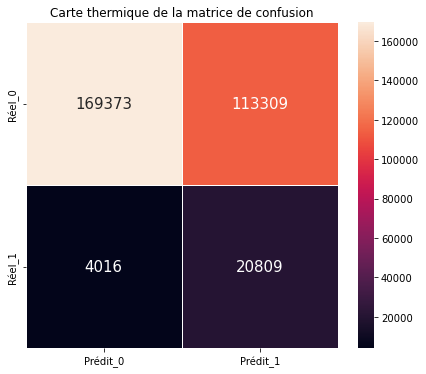

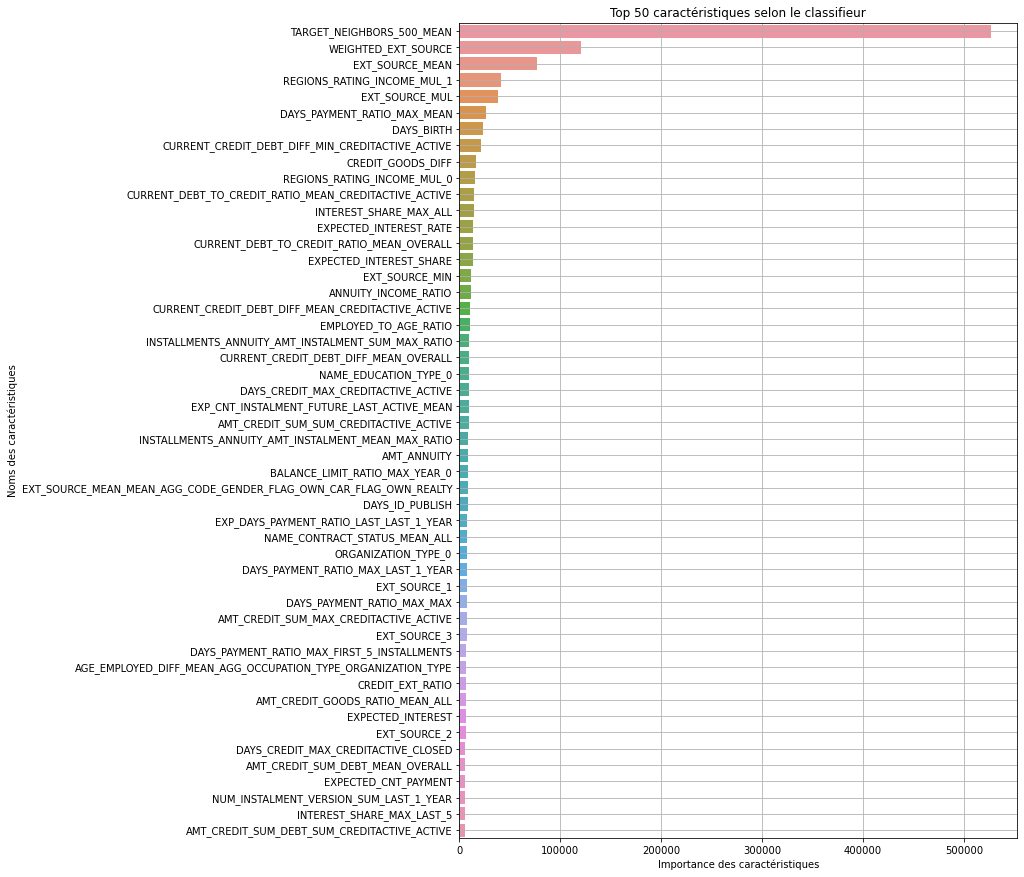

In [58]:
# Affichage des résultats et des métriques
lgbm_boosting.results()
# Affichage des 50 principales caractéristiques importantes
lgbm_boosting.feat_importances_show(50)

In [59]:
features_with_zero_importances = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"Il y a {len(features_with_zero_importances)} caractéristiques avec un gain nul dans LGBMClassifier. Ce sont :\n")
print(features_with_zero_importances.features.values)

Il y a 42 caractéristiques avec un gain nul dans LGBMClassifier. Ce sont :

['FLAG_DOCUMENT_17' 'FLAG_DOCUMENT_14' 'FLAG_OWN_CAR_1' 'FLAG_EMP_PHONE'
 'FLAG_MOBIL' 'CNT_CREDIT_PROLONG_SUM_CREDITACTIVE_CLOSED'
 'FLAG_DOCUMENT_7' 'FLAG_DOCUMENT_19' 'FLAG_CONT_MOBILE'
 'FLAG_DOCUMENT_11' 'CONTRACT_DEMAND_MEAN'
 'CNT_PROLONGED_DURATION_RATIO_MEAN_OVERALL'
 'CREDIT_TYPE_Loan for the purchase of equipment_MEAN_OVERALL'
 'CURRENT_DEBT_TO_CREDIT_RATIO_MEANCREDIT_ACTIVE_REST'
 'CURRENCY_currency 4_MEAN_OVERALL' 'CURRENCY_currency 2_MEAN_OVERALL'
 'CURRENCY_currency 1_MEAN_OVERALL'
 'DAYS_CREDIT_ENDDATE_MAX_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MEAN_CREDITACTIVE_CLOSED'
 'DAYS_CREDIT_ENDDATE_MEAN_OVERALL' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'CREDIT_TYPE_Unknown type of loan_MEAN_OVERALL'
 'CREDIT_TYPE_Real estate loan_MEAN_OVERALL'
 'CREDIT_TYPE_Mobile operator loan_MEAN_OVERALL'
 'RATE_INTEREST_PRIVILEGED_MEAN_LAST_5'
 'CREDIT_TYPE_Loan for working capital replenishment_MEAN_OVERALL'
 'CREDIT_TYP

In [60]:
with open('lgbm_imp_feats.pkl','wb') as f:
    pickle.dump(lgbm_boosting.feature_importance, f)
with open('lgbm_cv_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.cv_preds_proba, f)
with open('lgbm_test_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.test_preds_proba_mean, f)

<b>Discussion des résultats</b>

<ul>
    <li>Tout d'abord, nous constatons que le modèle LightGBM performe moins bien que le modèle XGBoost, comme on peut le voir à partir des résultats du score privé sur les données de test. Cela est contraire au fait que LightGBM a montré une valeur AUC plus élevée pour l'ensemble de données de validation croisée (CV) par rapport à XGBoost.</li>
    <li>Encore une fois, les valeurs de rappel (recall) sont assez élevées, ce qui est une bonne chose, mais les valeurs de précision (precision) ne sont pas bonnes. La valeur de rappel élevée suggère que la plupart des défaillants réels sont prédits par le modèle, mais la faible précision indique également que le modèle prédit de nombreux individus comme défaillants alors qu'ils ne le sont pas en réalité.</li>
    <li>Nous constatons dans la matrice de confusion que le nombre de vrais positifs est inférieur dans le cas de LightGBM par rapport à XGBoost. Cependant, le nombre total de faux positifs est également légèrement inférieur pour LightGBM.</li>
    <li>Nous observons également que les deux méthodes de boosting montrent le plus grand nombre de vrais positifs parmi tous les modèles. Cela est favorisé par la valeur de rappel élevée pour ces modèles également.</li>
</ul>

<ul><b>Importance des caractéristiques</b>
    <li>Nous constatons que la caractéristique "TARGET Mean of 500 neighbors" obtient un score assez élevé par rapport à toutes les autres caractéristiques. La différence de gain est très significative. Cela implique que cette caractéristique est en effet très importante.</li>
    <li>De manière similaire à tous les autres ensembles, les caractéristiques "EXT_SOURCE" obtiennent également un score élevé.</li>
    <li>Une des caractéristiques intéressantes ayant un score élevé pour LightGBM est "REGIONS_RATING_INCOME_MUL_1", qui est la multiplication de la note de la région du client par son revenu. Elle a été traitée comme une caractéristique catégorielle et a été codée en réponse, ce qui donne de meilleurs résultats que lorsqu'elle est traitée comme une caractéristique numérique.</li>
    <li>Nous observons également qu'il y a environ 42 caractéristiques qui ont un gain de 0 dans LGBMClassifier pour le fractionnement. Cela signifie qu'elles ne sont pas utiles pour notre classifieur.</li>
</ul>

# Résumé des résultats

In [63]:
import pandas as pd

import pandas as pd

results_df = pd.DataFrame([['Random Model', np.round(0.49953675730110775, 5), '-', np.round(0.49865535410697415, 5), '-'],
                          ['Dominant Class', 0.0, '-', np.round(0.499267622239582, 5), '-'],
                          ['SGD LogisticRegression L2', np.round(0.7439274924471299, 5), np.round(0.7326888217522659, 5), 
                           np.round(0.7967199301086765, 5), np.round(0.7907636938949894, 5)],
                          ['SGD Linear SVM', np.round(0.7311983887210474, 5), np.round(0.7222557905337361, 5), 
                           np.round(0.7981013689525606, 5), np.round(0.7915152564010789, 5)],
                          ['XGBoostClassifier', np.round(0.8003222557905337, 5), np.round(0.8621550855991944, 5), 
                           np.round(0.874621271791155, 5), np.round(0.8051792519121244, 5)],
                          ['XGBoostClassifier - 600 Features', np.round(0.7916616314199396, 5), np.round(0.8654179254783484, 5), 
                           np.round(0.8673657660778006, 5), np.round(0.804902562181455, 5)],
                          ['LightGBMClassifier', np.round(0.8208660624370594, 5), np.round(0.8382275931520644, 5), 
                           np.round(0.9026790150249289, 5), np.round(0.8060201697860073, 5)]],
                         columns=['Model', 'Train Recall', 'CV Recall', 'Train ROC-AUC', 'CV ROC-AUC'],
                         index=list(range(1, 8)))

display(results_df)

,Model,Train Recall,CV Recall,Train ROC-AUC,CV ROC-AUC
1,Random Model,0.49954,-,0.49866,-
2,Dominant Class,0.00000,-,0.49927,-
3,SGD LogisticRegression L2,0.74393,0.73269,0.79672,0.79076
4,SGD Linear SVM,0.73120,0.72226,0.79810,0.79152
5,XGBoostClassifier,0.80032,0.86216,0.87462,0.80518
6,XGBoostClassifier - 600 Features,0.79166,0.86542,0.86737,0.8049
7,LightGBMClassifier,0.82087,0.83823,0.90268,0.80602


Les résultats affichés représentent les performances de différents modèles de classification sur notre jeu de données. Voici une interprétation des résultats et une comparaison entre les familles de modèles.

1. Random Model:
   - Train Recall: 0.49954
   - CV Recall: 0.49866
   - Train ROC-AUC: N/A
   - CV ROC-AUC: N/A

   Ce modèle est utilisé comme point de référence et il attribue les prédictions de manière aléatoire. Les scores de rappel (recall) sont proches de 0.5, ce qui signifie qu'il ne parvient pas à faire des prédictions significativement meilleures que le hasard.

2. Dominant Class:
   - Train Recall: 0.0
   - CV Recall: 0.49927
   - Train ROC-AUC: N/A
   - CV ROC-AUC: N/A

   Ce modèle prédit toujours la classe majoritaire. Le score de rappel sur l'ensemble d'entraînement est de 0.0, ce qui signifie qu'il ne parvient pas à prédire la classe minoritaire du tout. Le score de rappel sur la validation croisée est légèrement meilleur mais toujours assez faible.

3. SGD LogisticRegression L2:
   - Train Recall: 0.74393
   - CV Recall: 0.73269
   - Train ROC-AUC: 0.79672
   - CV ROC-AUC: 0.79076

   Ce modèle utilise une régression logistique avec une régularisation L2 et l'optimiseur SGD (descente de gradient stochastique). Il présente de bons scores de rappel et de ROC-AUC sur les ensembles d'entraînement et de validation croisée.

4. SGD Linear SVM:
   - Train Recall: 0.73120
   - CV Recall: 0.72226
   - Train ROC-AUC: 0.79810
   - CV ROC-AUC: 0.79152

   Ce modèle utilise une machine à vecteurs de support (SVM) linéaire avec l'optimiseur SGD. Il obtient des scores similaires au modèle précédent en termes de rappel et de ROC-AUC.

5. XGBoostClassifier:
   - Train Recall: 0.80032
   - CV Recall: 0.86216
   - Train ROC-AUC: 0.87462
   - CV ROC-AUC: 0.80518

   Ce modèle utilise l'algorithme XGBoost pour le boosting de nombreux arbres de décision. Il affiche de bons scores de rappel et de ROC-AUC sur l'ensemble d'entraînement et obtient des performances légèrement meilleures sur la validation croisée.

6. XGBoostClassifier - 600 Features:
   - Train Recall: 0.79166
   - CV Recall: 0.86542
   - Train ROC-AUC: 0.86737
   - CV ROC-AUC: 0.80490

   Ce modèle est une variante du précédent, mais utilisant seulement 600 des caractéristiques d'origine. Bien qu'il utilise moins de caractéristiques, il parvient à obtenir des performances similaires sur l'ensemble d'entraînement et légèrement meilleures sur la validation croisée.

7. LightGBMClassifier:
   - Train Recall: 0.82087
   - CV Recall: 0.83823
   - Train ROC-AUC: 0.90268
   - CV ROC-AUC: 0.80602

   Ce modèle utilise l'algorithme LightGBM, qui est également basé sur le boosting d'arbres de décision. Il présente les meilleurs scores de rappel et de ROC-AUC sur l'ensemble d'entraînement, et des performances légèrement inférieures sur la validation croisée par rapport au modèle XGBoostClassifier.

En résumé, en comparant les familles de modèles :

- Les modèles basés sur les algorithmes de boosting (XGBoostClassifier et LightGBMClassifier) obtiennent généralement de meilleures performances que les modèles utilisant la régression logistique (SGD LogisticRegression L2) ou les SVM linéaires (SGD Linear SVM).
- Le modèle LightGBMClassifier se démarque en ayant les meilleurs scores de rappel et de ROC-AUC sur l'ensemble d'entraînement, mais légèrement inférieurs sur la validation croisée par rapport au XGBoostClassifier.
- Le modèle XGBoostClassifier - 600 Features utilise moins de caractéristiques mais parvient à obtenir des performances similaires à son homologue XGBoostClassifier.
- Les modèles de référence (Random Model et Dominant Class) ont des performances médiocres, montrant la nécessité d'utiliser des modèles plus avancés pour obtenir de meilleures prédictions.

# DataFrame final avec des fonctionnalités réduites pour la pipeline

Sur la base des fonctionnalités éliminées ci-dessus, nous les supprimerons des tables relationnelles, qui seront chargées en mémoire pendant la mise en production, afin de les fusionner avec les principaux points de données d'application_test.

In [73]:
relational_tables_prepare()

Chargement des tables en mémoire...
Terminé.
Temps écoulé = 0:00:28.166943

Suppression des fonctionnalités non utiles...
Terminé.
Temps écoulé = 0:00:00.623820

Fusion de toutes les tables et enregistrement dans le fichier pickle 'relational_table.pkl'...
Terminé.
Temps total écoulé = 0:00:44.080861
